<a href="https://colab.research.google.com/github/hamza3e/machine-learning-examples/blob/master/generative_dogs_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
from google.colab import files
uploaded = files.upload()


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
!kaggle competitions download -c generative-dog-images

100% 739M/739M [00:04<00:00, 149MB/s]

 30% 5.00M/16.8M [00:00<00:01, 12.1MB/s]
100% 16.8M/16.8M [00:00<00:00, 34.2MB/s]


In [0]:
!mkdir all-dogs
!unzip all-dogs.zip ../content/alldogs/

Archive:  all-dogs.zip
caution: filename not matched:  ../content/alldogs/


In [0]:
# importing the libraries

from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

There are 20579 pictures of dogs.


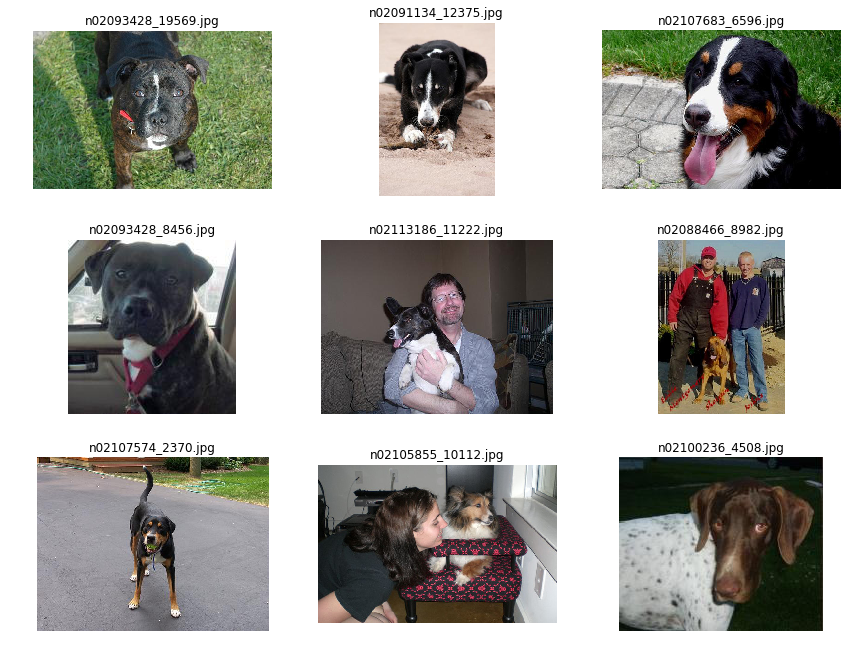

In [0]:
PATH = '../content/alldogs/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [0]:
# Augmentations
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [0]:
# Data loader
train_data = datasets.ImageFolder('../content/all-dogs/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


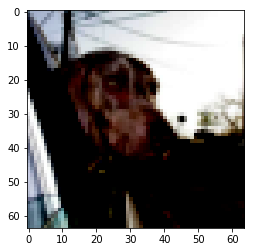

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


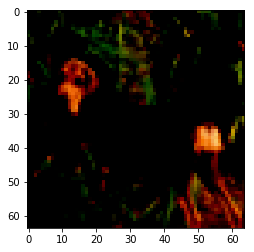

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


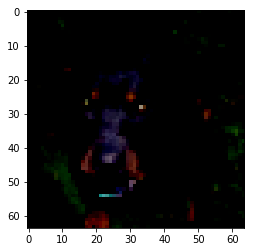

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


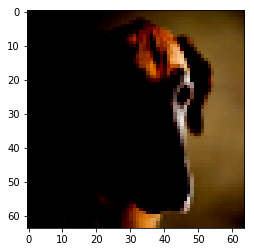

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


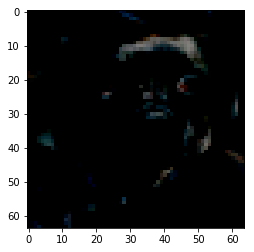

In [0]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

In [0]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )


    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img


In [0]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

In [0]:
batch_size = 32
lr = 0.001
beta1 = 0.5
epochs = 200

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

In [0]:
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.imshow(gen_image)
    plt.show()

[1/200][322/644] Loss_D: 0.9480 Loss_G: 1.7169 D(x): 0.6679 D(G(z)): 0.3606 / 0.1637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/200][644/644] Loss_D: 1.1602 Loss_G: 2.8468 D(x): 0.5950 D(G(z)): 0.4357 / 0.0427



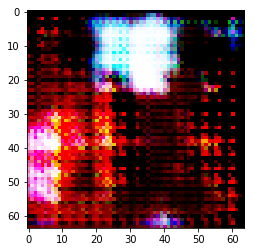

[2/200][322/644] Loss_D: 1.5851 Loss_G: 1.0185 D(x): 0.3687 D(G(z)): 0.4416 / 0.3673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/200][644/644] Loss_D: 2.2872 Loss_G: 1.3723 D(x): 0.1752 D(G(z)): 0.4705 / 0.2511



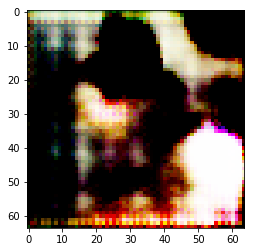

[3/200][322/644] Loss_D: 1.1872 Loss_G: 1.8523 D(x): 0.6395 D(G(z)): 0.4380 / 0.1434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/200][644/644] Loss_D: 2.2410 Loss_G: 1.3674 D(x): 0.1662 D(G(z)): 0.3831 / 0.2875



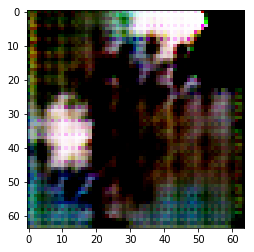

[4/200][322/644] Loss_D: 1.1151 Loss_G: 1.4221 D(x): 0.4544 D(G(z)): 0.2310 / 0.2266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/200][644/644] Loss_D: 1.5416 Loss_G: 3.1050 D(x): 0.4081 D(G(z)): 0.4868 / 0.0328



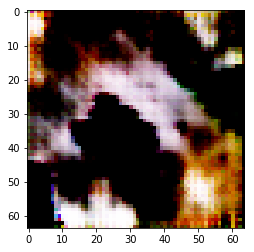

[5/200][322/644] Loss_D: 1.4313 Loss_G: 1.0834 D(x): 0.5004 D(G(z)): 0.4702 / 0.3422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/200][644/644] Loss_D: 1.5529 Loss_G: 3.2944 D(x): 0.5985 D(G(z)): 0.6176 / 0.0472



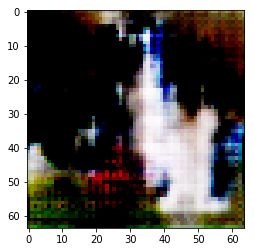

[6/200][322/644] Loss_D: 1.2965 Loss_G: 1.1059 D(x): 0.5242 D(G(z)): 0.4468 / 0.3201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/200][644/644] Loss_D: 1.9107 Loss_G: 2.3118 D(x): 0.2515 D(G(z)): 0.4403 / 0.0817



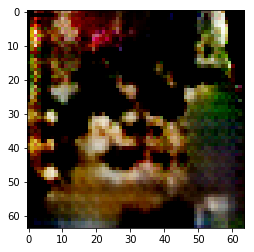

[7/200][322/644] Loss_D: 1.4168 Loss_G: 1.3850 D(x): 0.5762 D(G(z)): 0.5002 / 0.2478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/200][644/644] Loss_D: 0.7169 Loss_G: 2.3327 D(x): 0.6634 D(G(z)): 0.1728 / 0.0763



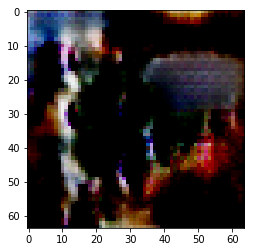

[8/200][322/644] Loss_D: 1.3605 Loss_G: 1.5542 D(x): 0.5525 D(G(z)): 0.4802 / 0.1979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/200][644/644] Loss_D: 0.9303 Loss_G: 2.4569 D(x): 0.5731 D(G(z)): 0.2704 / 0.0675



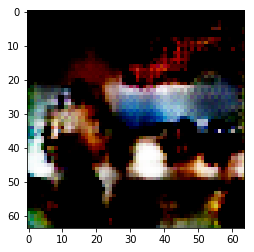

[9/200][322/644] Loss_D: 1.0857 Loss_G: 1.1936 D(x): 0.4779 D(G(z)): 0.2733 / 0.2930


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/200][644/644] Loss_D: 1.9230 Loss_G: 1.4055 D(x): 0.2157 D(G(z)): 0.3490 / 0.2508



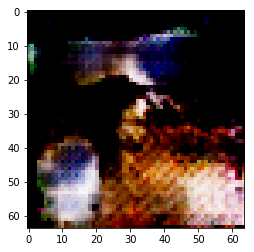

[10/200][322/644] Loss_D: 1.0935 Loss_G: 1.2747 D(x): 0.4720 D(G(z)): 0.2351 / 0.2809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/200][644/644] Loss_D: 1.3235 Loss_G: 1.4468 D(x): 0.3407 D(G(z)): 0.2463 / 0.2298



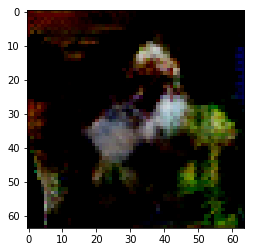

[11/200][322/644] Loss_D: 1.0453 Loss_G: 1.5567 D(x): 0.6157 D(G(z)): 0.3702 / 0.1953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/200][644/644] Loss_D: 1.4188 Loss_G: 1.9497 D(x): 0.3219 D(G(z)): 0.2763 / 0.1319



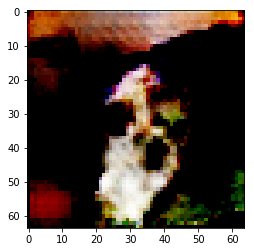

[12/200][322/644] Loss_D: 1.0798 Loss_G: 1.4139 D(x): 0.5166 D(G(z)): 0.2761 / 0.2361


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/200][644/644] Loss_D: 1.7036 Loss_G: 3.8530 D(x): 0.4908 D(G(z)): 0.5872 / 0.0205



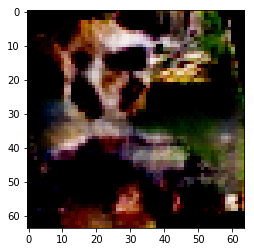

[13/200][322/644] Loss_D: 1.2701 Loss_G: 1.1702 D(x): 0.4148 D(G(z)): 0.3046 / 0.3044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/200][644/644] Loss_D: 1.8169 Loss_G: 2.0948 D(x): 0.2524 D(G(z)): 0.3746 / 0.1077



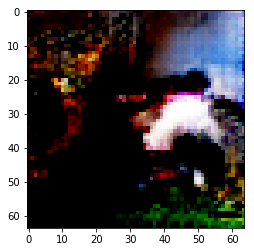

[14/200][322/644] Loss_D: 1.0455 Loss_G: 1.4074 D(x): 0.4905 D(G(z)): 0.2424 / 0.2324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/200][644/644] Loss_D: 1.3506 Loss_G: 1.8123 D(x): 0.3420 D(G(z)): 0.2403 / 0.1757



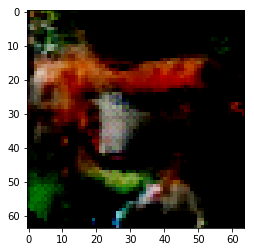

[15/200][322/644] Loss_D: 1.2286 Loss_G: 1.1585 D(x): 0.5880 D(G(z)): 0.4462 / 0.3028


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/200][644/644] Loss_D: 1.8462 Loss_G: 3.0693 D(x): 0.2757 D(G(z)): 0.4191 / 0.0758



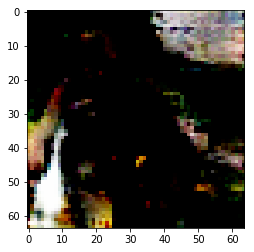

[16/200][322/644] Loss_D: 1.3189 Loss_G: 1.1911 D(x): 0.4465 D(G(z)): 0.3568 / 0.3156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/200][644/644] Loss_D: 1.0903 Loss_G: 2.2077 D(x): 0.5133 D(G(z)): 0.2724 / 0.1011



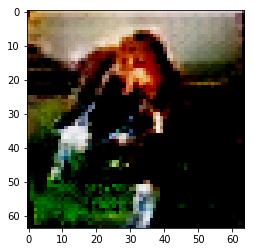

[17/200][322/644] Loss_D: 1.2162 Loss_G: 1.3930 D(x): 0.6353 D(G(z)): 0.4579 / 0.2381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/200][644/644] Loss_D: 1.1122 Loss_G: 1.6650 D(x): 0.3722 D(G(z)): 0.1395 / 0.2016



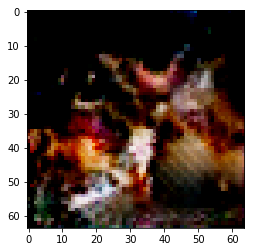

[18/200][322/644] Loss_D: 1.1186 Loss_G: 1.5162 D(x): 0.6260 D(G(z)): 0.3869 / 0.2195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/200][644/644] Loss_D: 0.5516 Loss_G: 3.6117 D(x): 0.7147 D(G(z)): 0.1015 / 0.0227



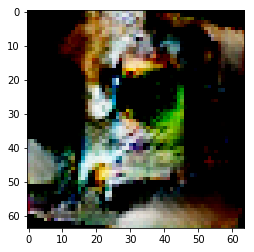

[19/200][322/644] Loss_D: 1.2109 Loss_G: 1.4572 D(x): 0.4747 D(G(z)): 0.3052 / 0.2508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/200][644/644] Loss_D: 1.0630 Loss_G: 5.5644 D(x): 0.6109 D(G(z)): 0.3913 / 0.0077



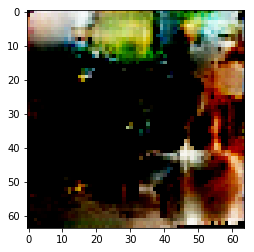

[20/200][322/644] Loss_D: 0.8826 Loss_G: 1.9947 D(x): 0.7560 D(G(z)): 0.3521 / 0.1262


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/200][644/644] Loss_D: 1.0046 Loss_G: 3.8325 D(x): 0.6271 D(G(z)): 0.3333 / 0.0475



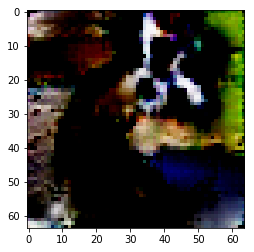

[21/200][322/644] Loss_D: 1.1041 Loss_G: 1.5432 D(x): 0.6452 D(G(z)): 0.4101 / 0.2015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/200][644/644] Loss_D: 0.9340 Loss_G: 2.4161 D(x): 0.5259 D(G(z)): 0.1821 / 0.0833



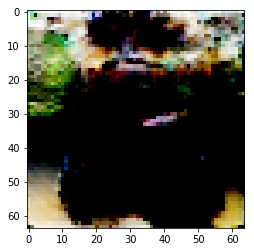

[22/200][322/644] Loss_D: 1.1148 Loss_G: 1.6824 D(x): 0.6516 D(G(z)): 0.4146 / 0.1832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/200][644/644] Loss_D: 2.0832 Loss_G: 2.5029 D(x): 0.1980 D(G(z)): 0.3056 / 0.2422



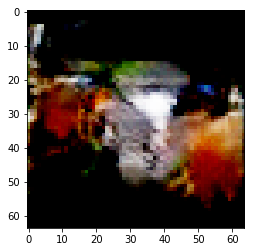

[23/200][322/644] Loss_D: 1.1206 Loss_G: 1.2290 D(x): 0.4161 D(G(z)): 0.1759 / 0.3096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/200][644/644] Loss_D: 1.2363 Loss_G: 1.8920 D(x): 0.3230 D(G(z)): 0.1331 / 0.1683



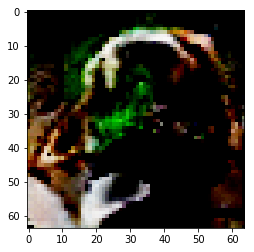

[24/200][322/644] Loss_D: 1.1906 Loss_G: 1.3434 D(x): 0.5039 D(G(z)): 0.3308 / 0.2595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/200][644/644] Loss_D: 1.3667 Loss_G: 1.9013 D(x): 0.2676 D(G(z)): 0.1147 / 0.1247



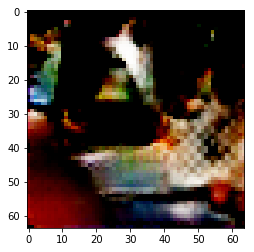

[25/200][322/644] Loss_D: 1.0496 Loss_G: 1.2228 D(x): 0.5554 D(G(z)): 0.2707 / 0.3087


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/200][644/644] Loss_D: 0.4608 Loss_G: 3.6857 D(x): 0.7832 D(G(z)): 0.0711 / 0.0191



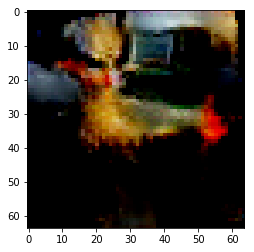

[26/200][322/644] Loss_D: 0.8493 Loss_G: 1.8305 D(x): 0.5627 D(G(z)): 0.1677 / 0.1580


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[26/200][644/644] Loss_D: 1.0468 Loss_G: 1.7147 D(x): 0.3527 D(G(z)): 0.0535 / 0.1522



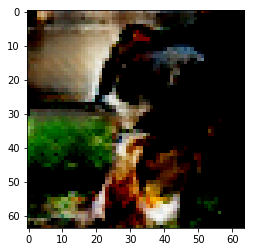

[27/200][322/644] Loss_D: 1.0509 Loss_G: 1.3265 D(x): 0.4588 D(G(z)): 0.1591 / 0.2869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[27/200][644/644] Loss_D: 0.6528 Loss_G: 3.4438 D(x): 0.7249 D(G(z)): 0.1149 / 0.0223



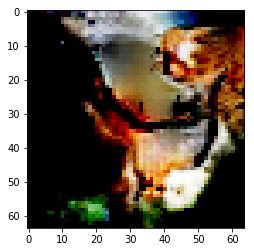

[28/200][322/644] Loss_D: 0.9138 Loss_G: 2.0028 D(x): 0.6952 D(G(z)): 0.3311 / 0.1256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[28/200][644/644] Loss_D: 0.9394 Loss_G: 1.3552 D(x): 0.4117 D(G(z)): 0.0379 / 0.2622



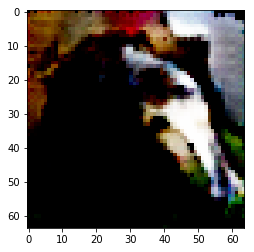

[29/200][322/644] Loss_D: 0.8421 Loss_G: 2.1256 D(x): 0.6788 D(G(z)): 0.2556 / 0.1113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29/200][644/644] Loss_D: 0.7754 Loss_G: 2.0483 D(x): 0.5477 D(G(z)): 0.0917 / 0.1109



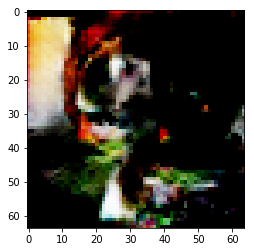

[30/200][322/644] Loss_D: 1.0848 Loss_G: 1.2996 D(x): 0.5097 D(G(z)): 0.2285 / 0.2782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[30/200][644/644] Loss_D: 1.6565 Loss_G: 1.1824 D(x): 0.2260 D(G(z)): 0.0313 / 0.4618



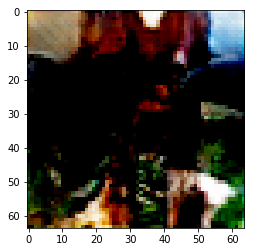

[31/200][322/644] Loss_D: 0.9269 Loss_G: 2.0392 D(x): 0.6232 D(G(z)): 0.2589 / 0.1301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31/200][644/644] Loss_D: 1.5517 Loss_G: 2.4689 D(x): 0.3959 D(G(z)): 0.1507 / 0.0719



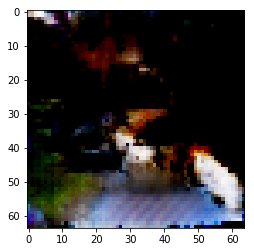

[32/200][322/644] Loss_D: 0.9575 Loss_G: 1.5839 D(x): 0.6337 D(G(z)): 0.3053 / 0.2028


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[32/200][644/644] Loss_D: 1.1864 Loss_G: 2.2430 D(x): 0.3517 D(G(z)): 0.1599 / 0.0927



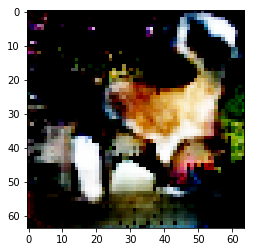

[33/200][322/644] Loss_D: 0.9790 Loss_G: 1.8889 D(x): 0.5931 D(G(z)): 0.2586 / 0.1487


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[33/200][644/644] Loss_D: 0.8053 Loss_G: 4.8963 D(x): 0.6418 D(G(z)): 0.2508 / 0.0052



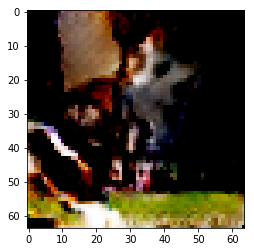

[34/200][322/644] Loss_D: 0.9337 Loss_G: 2.5248 D(x): 0.8284 D(G(z)): 0.3752 / 0.0796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[34/200][644/644] Loss_D: 0.5303 Loss_G: 3.2031 D(x): 0.7808 D(G(z)): 0.1401 / 0.0323



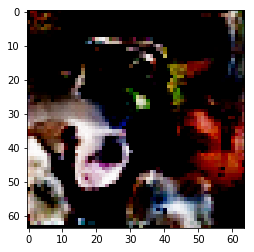

[35/200][322/644] Loss_D: 0.8995 Loss_G: 1.8890 D(x): 0.6367 D(G(z)): 0.2459 / 0.1479


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[35/200][644/644] Loss_D: 1.0025 Loss_G: 2.1320 D(x): 0.4647 D(G(z)): 0.1315 / 0.1103



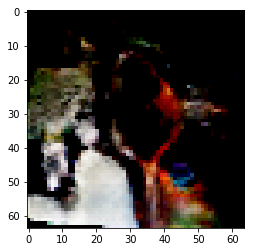

[36/200][322/644] Loss_D: 0.8624 Loss_G: 1.9812 D(x): 0.6110 D(G(z)): 0.2169 / 0.1300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[36/200][644/644] Loss_D: 0.5870 Loss_G: 4.4013 D(x): 0.7312 D(G(z)): 0.0929 / 0.0078



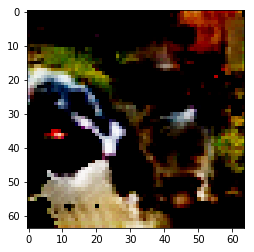

[37/200][322/644] Loss_D: 0.8601 Loss_G: 2.3521 D(x): 0.5954 D(G(z)): 0.1836 / 0.1055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[37/200][644/644] Loss_D: 0.9416 Loss_G: 8.3463 D(x): 0.6711 D(G(z)): 0.3079 / 0.0006



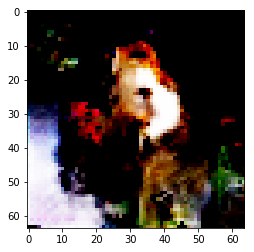

[38/200][322/644] Loss_D: 1.0242 Loss_G: 2.0884 D(x): 0.7969 D(G(z)): 0.4035 / 0.1141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[38/200][644/644] Loss_D: 0.8585 Loss_G: 4.5202 D(x): 0.5667 D(G(z)): 0.1711 / 0.0621



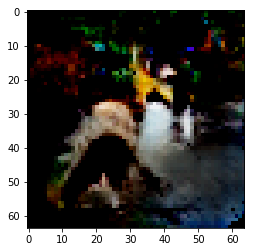

[39/200][322/644] Loss_D: 0.9576 Loss_G: 1.9632 D(x): 0.7599 D(G(z)): 0.3598 / 0.1346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[39/200][644/644] Loss_D: 1.6325 Loss_G: 0.9138 D(x): 0.1961 D(G(z)): 0.0761 / 0.4617



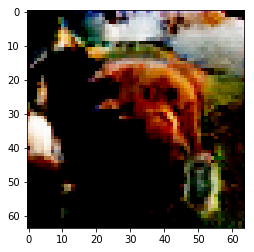

[40/200][322/644] Loss_D: 0.9101 Loss_G: 1.9874 D(x): 0.5829 D(G(z)): 0.1750 / 0.1318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[40/200][644/644] Loss_D: 1.9354 Loss_G: 3.8352 D(x): 0.1950 D(G(z)): 0.2982 / 0.0657



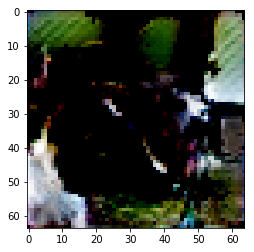

[41/200][322/644] Loss_D: 0.8337 Loss_G: 2.3709 D(x): 0.8021 D(G(z)): 0.2937 / 0.0889


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[41/200][644/644] Loss_D: 0.5153 Loss_G: 3.0633 D(x): 0.6759 D(G(z)): 0.0116 / 0.0366



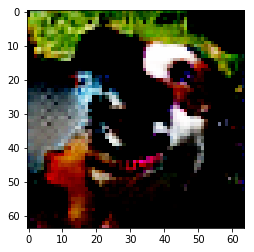

[42/200][322/644] Loss_D: 0.8481 Loss_G: 1.8719 D(x): 0.6480 D(G(z)): 0.2141 / 0.1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[42/200][644/644] Loss_D: 2.4751 Loss_G: 1.0740 D(x): 0.0893 D(G(z)): 0.0159 / 0.3504



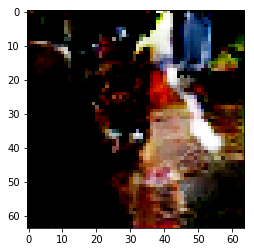

[43/200][322/644] Loss_D: 1.2294 Loss_G: 1.6955 D(x): 0.3508 D(G(z)): 0.0502 / 0.2046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[43/200][644/644] Loss_D: 1.3943 Loss_G: 0.3544 D(x): 0.2517 D(G(z)): 0.0142 / 0.9336



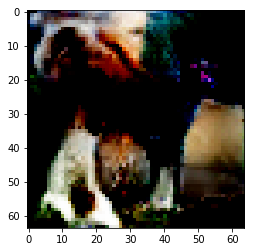

[44/200][322/644] Loss_D: 0.8166 Loss_G: 1.8024 D(x): 0.6565 D(G(z)): 0.1852 / 0.1726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[44/200][644/644] Loss_D: 1.0005 Loss_G: 7.1037 D(x): 0.6872 D(G(z)): 0.3151 / 0.0016



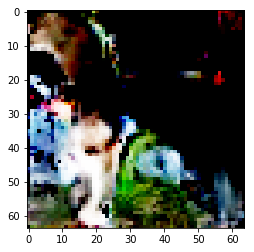

[45/200][322/644] Loss_D: 0.8365 Loss_G: 1.7370 D(x): 0.5691 D(G(z)): 0.1531 / 0.1929


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[45/200][644/644] Loss_D: 0.4437 Loss_G: 4.0463 D(x): 0.7748 D(G(z)): 0.0595 / 0.0115



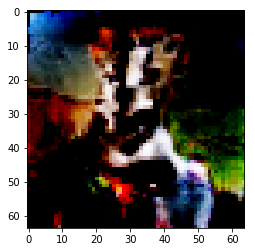

[46/200][322/644] Loss_D: 1.4139 Loss_G: 3.0856 D(x): 0.9606 D(G(z)): 0.5426 / 0.0416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[46/200][644/644] Loss_D: 1.0818 Loss_G: 4.6045 D(x): 0.5595 D(G(z)): 0.3565 / 0.0185



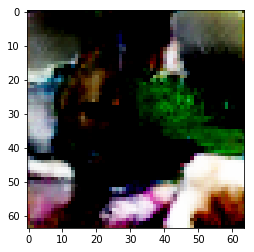

[47/200][322/644] Loss_D: 0.9137 Loss_G: 2.1570 D(x): 0.6069 D(G(z)): 0.1869 / 0.1213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[47/200][644/644] Loss_D: 0.4780 Loss_G: 4.7559 D(x): 0.8034 D(G(z)): 0.0761 / 0.0051



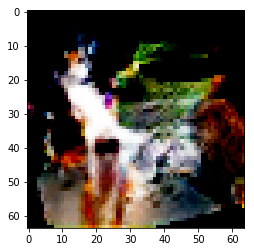

[48/200][322/644] Loss_D: 0.9609 Loss_G: 1.9963 D(x): 0.6494 D(G(z)): 0.3001 / 0.1275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[48/200][644/644] Loss_D: 0.4239 Loss_G: 3.8649 D(x): 0.8971 D(G(z)): 0.0302 / 0.0137



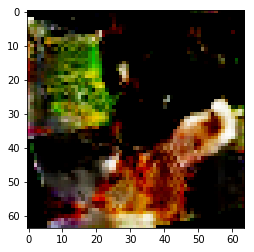

[49/200][322/644] Loss_D: 0.6796 Loss_G: 2.3491 D(x): 0.7626 D(G(z)): 0.1753 / 0.0975


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[49/200][644/644] Loss_D: 2.4008 Loss_G: 8.1920 D(x): 0.3410 D(G(z)): 0.4605 / 0.0009



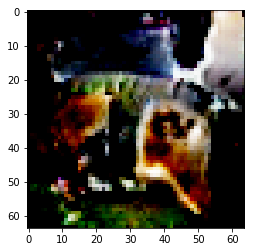

[50/200][322/644] Loss_D: 0.7361 Loss_G: 2.4206 D(x): 0.7958 D(G(z)): 0.2475 / 0.0944


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[50/200][644/644] Loss_D: 2.9373 Loss_G: 5.8508 D(x): 0.3342 D(G(z)): 0.4197 / 0.0027



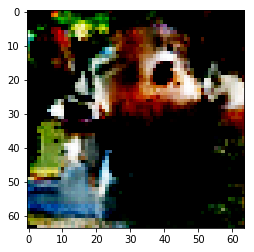

[51/200][322/644] Loss_D: 1.0731 Loss_G: 3.0322 D(x): 0.8493 D(G(z)): 0.4369 / 0.0478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[51/200][644/644] Loss_D: 2.1282 Loss_G: 5.8925 D(x): 0.1912 D(G(z)): 0.3595 / 0.0115



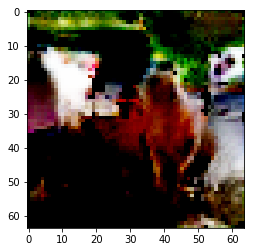

[52/200][322/644] Loss_D: 0.9468 Loss_G: 1.5771 D(x): 0.4978 D(G(z)): 0.1151 / 0.2382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[52/200][644/644] Loss_D: 1.1669 Loss_G: 1.0567 D(x): 0.3595 D(G(z)): 0.0364 / 0.3523



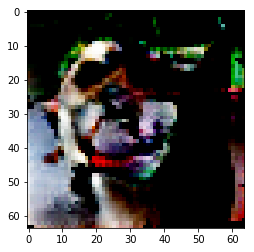

[53/200][322/644] Loss_D: 0.6959 Loss_G: 2.1347 D(x): 0.6576 D(G(z)): 0.1451 / 0.1172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[53/200][644/644] Loss_D: 2.0930 Loss_G: 1.3015 D(x): 0.1049 D(G(z)): 0.0042 / 0.4214



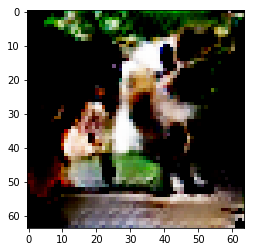

[54/200][322/644] Loss_D: 0.9291 Loss_G: 1.7571 D(x): 0.6668 D(G(z)): 0.2754 / 0.1766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[54/200][644/644] Loss_D: 1.1633 Loss_G: 6.6675 D(x): 0.6047 D(G(z)): 0.3022 / 0.0007



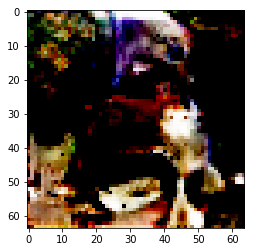

[55/200][322/644] Loss_D: 0.9739 Loss_G: 2.5558 D(x): 0.4817 D(G(z)): 0.0668 / 0.1018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[55/200][644/644] Loss_D: 0.8732 Loss_G: 4.9456 D(x): 0.5881 D(G(z)): 0.2253 / 0.0332



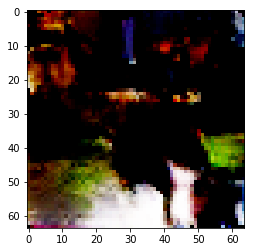

[56/200][322/644] Loss_D: 0.7413 Loss_G: 2.6334 D(x): 0.8500 D(G(z)): 0.2644 / 0.0785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[56/200][644/644] Loss_D: 0.6670 Loss_G: 3.9265 D(x): 0.6781 D(G(z)): 0.1055 / 0.0130



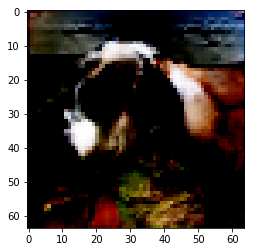

[57/200][322/644] Loss_D: 0.8764 Loss_G: 2.0791 D(x): 0.6767 D(G(z)): 0.2377 / 0.1383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[57/200][644/644] Loss_D: 3.1194 Loss_G: 1.2962 D(x): 0.0595 D(G(z)): 0.0107 / 0.3392



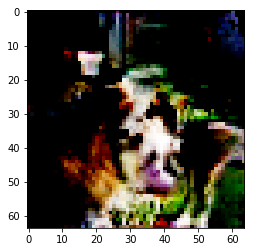

[58/200][322/644] Loss_D: 0.6625 Loss_G: 2.4732 D(x): 0.7674 D(G(z)): 0.1786 / 0.0826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[58/200][644/644] Loss_D: 0.5470 Loss_G: 2.3834 D(x): 0.7607 D(G(z)): 0.0323 / 0.0938



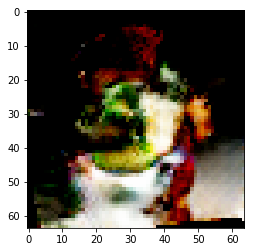

[59/200][322/644] Loss_D: 1.0548 Loss_G: 1.9313 D(x): 0.4552 D(G(z)): 0.1208 / 0.1677


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[59/200][644/644] Loss_D: 0.3974 Loss_G: 3.6322 D(x): 0.9362 D(G(z)): 0.0542 / 0.0188



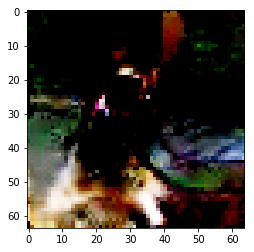

[60/200][322/644] Loss_D: 0.8897 Loss_G: 2.6636 D(x): 0.7227 D(G(z)): 0.2942 / 0.0685


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[60/200][644/644] Loss_D: 1.3376 Loss_G: 0.7523 D(x): 0.2745 D(G(z)): 0.0323 / 0.5091



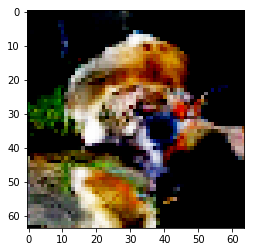

[61/200][322/644] Loss_D: 0.7489 Loss_G: 2.4170 D(x): 0.5894 D(G(z)): 0.0927 / 0.0970


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[61/200][644/644] Loss_D: 1.1032 Loss_G: 3.9310 D(x): 0.4674 D(G(z)): 0.1293 / 0.0311



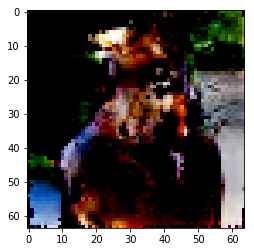

[62/200][322/644] Loss_D: 1.1718 Loss_G: 2.5589 D(x): 0.6835 D(G(z)): 0.4151 / 0.0818


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[62/200][644/644] Loss_D: 2.7382 Loss_G: 1.8859 D(x): 0.0656 D(G(z)): 0.2336 / 0.2063



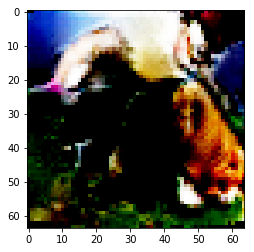

[63/200][322/644] Loss_D: 0.9832 Loss_G: 1.9399 D(x): 0.6092 D(G(z)): 0.2635 / 0.1462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[63/200][644/644] Loss_D: 0.4670 Loss_G: 5.6292 D(x): 0.9156 D(G(z)): 0.0911 / 0.0021



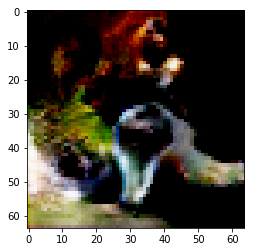

[64/200][322/644] Loss_D: 0.5416 Loss_G: 3.1819 D(x): 0.7704 D(G(z)): 0.1040 / 0.0436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[64/200][644/644] Loss_D: 0.6993 Loss_G: 2.5782 D(x): 0.5553 D(G(z)): 0.0674 / 0.0596



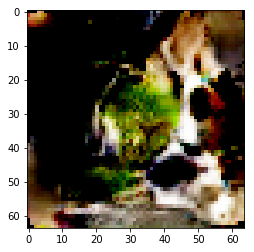

[65/200][322/644] Loss_D: 0.7377 Loss_G: 2.5667 D(x): 0.6990 D(G(z)): 0.1588 / 0.0831


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65/200][644/644] Loss_D: 0.6685 Loss_G: 3.6026 D(x): 0.5932 D(G(z)): 0.0528 / 0.0245



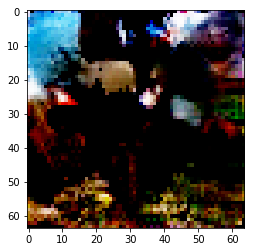

[66/200][322/644] Loss_D: 0.6905 Loss_G: 2.4479 D(x): 0.8360 D(G(z)): 0.2342 / 0.0868


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[66/200][644/644] Loss_D: 1.3156 Loss_G: 1.7270 D(x): 0.2662 D(G(z)): 0.0386 / 0.2962



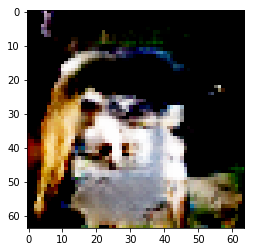

[67/200][322/644] Loss_D: 0.8824 Loss_G: 1.8324 D(x): 0.5221 D(G(z)): 0.0930 / 0.1751


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[67/200][644/644] Loss_D: 0.6303 Loss_G: 6.7730 D(x): 0.8058 D(G(z)): 0.1714 / 0.0034



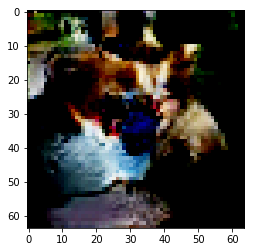

[68/200][322/644] Loss_D: 0.6127 Loss_G: 3.1862 D(x): 0.7279 D(G(z)): 0.1083 / 0.0418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[68/200][644/644] Loss_D: 0.9839 Loss_G: 2.4333 D(x): 0.3927 D(G(z)): 0.0129 / 0.0842



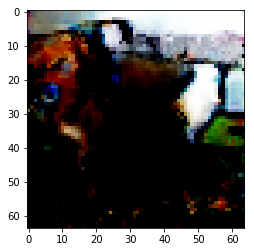

[69/200][322/644] Loss_D: 0.9234 Loss_G: 3.3273 D(x): 0.8218 D(G(z)): 0.3524 / 0.0406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[69/200][644/644] Loss_D: 2.0575 Loss_G: 3.4728 D(x): 0.2074 D(G(z)): 0.2420 / 0.1267



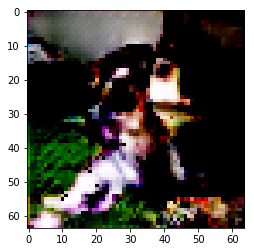

[70/200][322/644] Loss_D: 0.9306 Loss_G: 2.0592 D(x): 0.5625 D(G(z)): 0.1470 / 0.1515


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[70/200][644/644] Loss_D: 1.2262 Loss_G: 2.3122 D(x): 0.3095 D(G(z)): 0.0625 / 0.0801



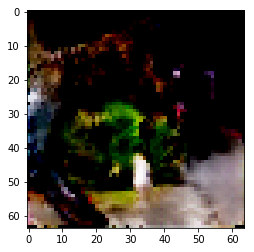

[71/200][322/644] Loss_D: 0.7880 Loss_G: 2.5808 D(x): 0.7194 D(G(z)): 0.1867 / 0.0710


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[71/200][644/644] Loss_D: 0.3503 Loss_G: 4.4619 D(x): 0.8999 D(G(z)): 0.0040 / 0.0071



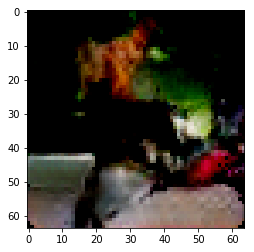

[72/200][322/644] Loss_D: 0.9255 Loss_G: 1.6700 D(x): 0.5604 D(G(z)): 0.1363 / 0.2134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[72/200][644/644] Loss_D: 1.1149 Loss_G: 0.9625 D(x): 0.3426 D(G(z)): 0.0380 / 0.4119



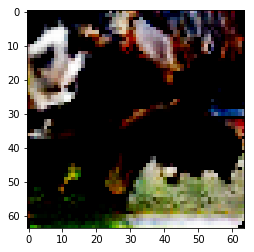

[73/200][322/644] Loss_D: 0.7479 Loss_G: 2.5139 D(x): 0.7727 D(G(z)): 0.2489 / 0.0801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[73/200][644/644] Loss_D: 3.6620 Loss_G: 4.0514 D(x): 0.1939 D(G(z)): 0.1783 / 0.0468



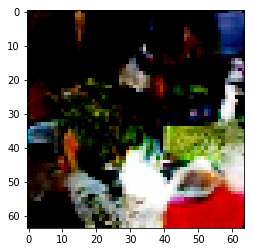

[74/200][322/644] Loss_D: 0.8164 Loss_G: 2.1863 D(x): 0.6108 D(G(z)): 0.1568 / 0.1266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[74/200][644/644] Loss_D: 1.0827 Loss_G: 3.1484 D(x): 0.3920 D(G(z)): 0.0364 / 0.1124



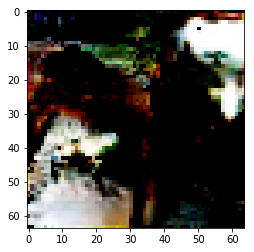

[75/200][322/644] Loss_D: 0.8851 Loss_G: 2.1732 D(x): 0.6106 D(G(z)): 0.1925 / 0.1330


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[75/200][644/644] Loss_D: 0.4378 Loss_G: 4.8268 D(x): 0.9449 D(G(z)): 0.0502 / 0.0051



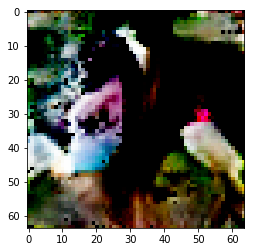

[76/200][322/644] Loss_D: 0.8915 Loss_G: 1.9746 D(x): 0.5754 D(G(z)): 0.1381 / 0.1861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[76/200][644/644] Loss_D: 1.8243 Loss_G: 15.8999 D(x): 0.9345 D(G(z)): 0.6474 / 0.0000



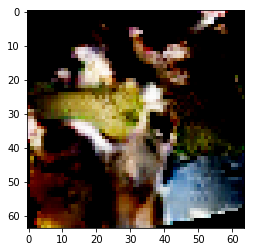

[77/200][322/644] Loss_D: 0.6569 Loss_G: 2.0227 D(x): 0.6840 D(G(z)): 0.1045 / 0.1693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[77/200][644/644] Loss_D: 0.5858 Loss_G: 7.2148 D(x): 0.9504 D(G(z)): 0.1861 / 0.0009



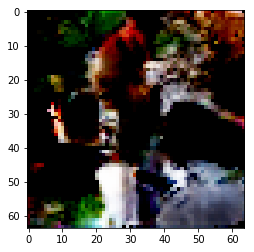

[78/200][322/644] Loss_D: 1.0686 Loss_G: 1.8059 D(x): 0.4404 D(G(z)): 0.0554 / 0.2057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[78/200][644/644] Loss_D: 0.5463 Loss_G: 4.5229 D(x): 0.7298 D(G(z)): 0.0772 / 0.0090



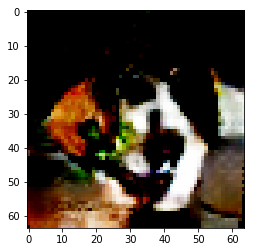

[79/200][322/644] Loss_D: 0.7656 Loss_G: 2.1637 D(x): 0.6386 D(G(z)): 0.1328 / 0.1383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[79/200][644/644] Loss_D: 1.1502 Loss_G: 2.3503 D(x): 0.3308 D(G(z)): 0.0411 / 0.0785



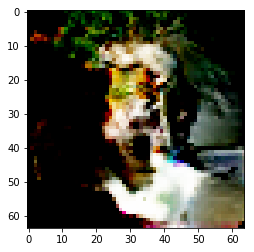

[80/200][322/644] Loss_D: 0.5553 Loss_G: 3.4523 D(x): 0.8589 D(G(z)): 0.1266 / 0.0365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[80/200][644/644] Loss_D: 3.1305 Loss_G: 1.3510 D(x): 0.0824 D(G(z)): 0.2151 / 0.3817



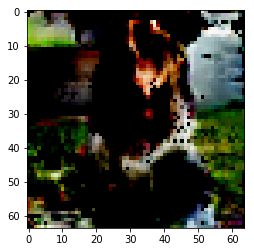

[81/200][322/644] Loss_D: 0.9128 Loss_G: 1.9375 D(x): 0.5457 D(G(z)): 0.1639 / 0.1611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[81/200][644/644] Loss_D: 0.8261 Loss_G: 1.9106 D(x): 0.4918 D(G(z)): 0.0201 / 0.1292



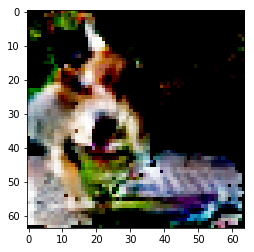

[82/200][322/644] Loss_D: 1.2313 Loss_G: 1.4872 D(x): 0.4144 D(G(z)): 0.1422 / 0.2478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[82/200][644/644] Loss_D: 0.5001 Loss_G: 3.5953 D(x): 0.6955 D(G(z)): 0.0376 / 0.0198



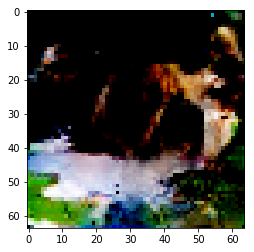

[83/200][322/644] Loss_D: 0.6920 Loss_G: 2.4421 D(x): 0.6342 D(G(z)): 0.0781 / 0.0995


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[83/200][644/644] Loss_D: 0.6459 Loss_G: 5.3046 D(x): 0.7315 D(G(z)): 0.1626 / 0.0049



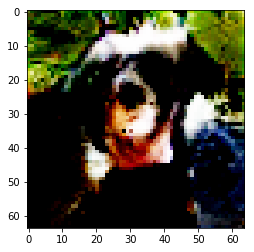

[84/200][322/644] Loss_D: 0.9023 Loss_G: 2.1622 D(x): 0.6414 D(G(z)): 0.2241 / 0.1309


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[84/200][644/644] Loss_D: 1.3090 Loss_G: 2.1878 D(x): 0.2902 D(G(z)): 0.0618 / 0.2417



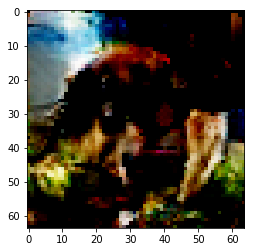

[85/200][322/644] Loss_D: 0.9402 Loss_G: 1.9545 D(x): 0.4687 D(G(z)): 0.0472 / 0.1814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[85/200][644/644] Loss_D: 1.3232 Loss_G: 1.6366 D(x): 0.2496 D(G(z)): 0.0331 / 0.3079



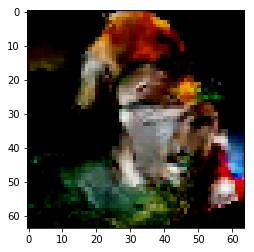

[86/200][322/644] Loss_D: 0.6590 Loss_G: 2.4005 D(x): 0.6993 D(G(z)): 0.1295 / 0.0872


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[86/200][644/644] Loss_D: 0.4573 Loss_G: 5.2002 D(x): 0.9807 D(G(z)): 0.0108 / 0.0033



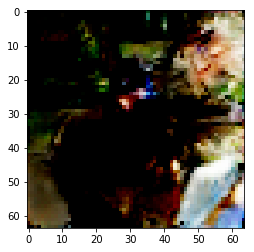

[87/200][322/644] Loss_D: 0.6597 Loss_G: 2.9427 D(x): 0.7494 D(G(z)): 0.1266 / 0.0499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[87/200][644/644] Loss_D: 1.1327 Loss_G: 2.9618 D(x): 0.3716 D(G(z)): 0.0159 / 0.0554



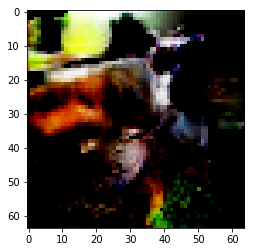

[88/200][322/644] Loss_D: 0.4411 Loss_G: 3.7166 D(x): 0.8315 D(G(z)): 0.0539 / 0.0319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[88/200][644/644] Loss_D: 0.5343 Loss_G: 5.8835 D(x): 0.7949 D(G(z)): 0.1064 / 0.0019



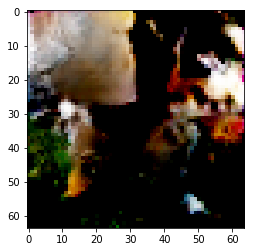

[89/200][322/644] Loss_D: 0.8695 Loss_G: 2.1789 D(x): 0.7046 D(G(z)): 0.2404 / 0.1201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[89/200][644/644] Loss_D: 2.9464 Loss_G: 14.6027 D(x): 0.5430 D(G(z)): 0.7761 / 0.0000



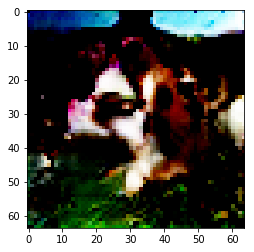

[90/200][322/644] Loss_D: 1.1825 Loss_G: 2.3408 D(x): 0.7980 D(G(z)): 0.4621 / 0.1036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[90/200][644/644] Loss_D: 0.9096 Loss_G: 1.6193 D(x): 0.4292 D(G(z)): 0.0155 / 0.1740



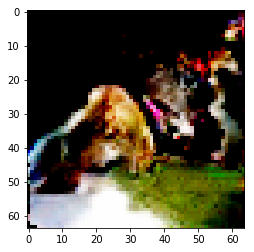

[91/200][322/644] Loss_D: 0.6953 Loss_G: 3.4498 D(x): 0.9118 D(G(z)): 0.2208 / 0.0333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[91/200][644/644] Loss_D: 0.8625 Loss_G: 5.9534 D(x): 0.5612 D(G(z)): 0.1671 / 0.0036



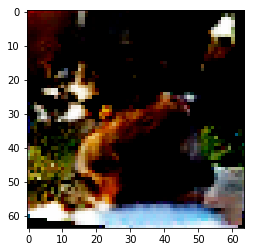

[92/200][322/644] Loss_D: 0.7488 Loss_G: 1.9833 D(x): 0.6555 D(G(z)): 0.1372 / 0.1527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[92/200][644/644] Loss_D: 1.0151 Loss_G: 1.1961 D(x): 0.4481 D(G(z)): 0.0822 / 0.2872



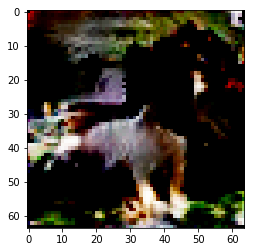

[93/200][322/644] Loss_D: 0.6505 Loss_G: 3.1087 D(x): 0.9042 D(G(z)): 0.2162 / 0.0469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[93/200][644/644] Loss_D: 0.8275 Loss_G: 10.2478 D(x): 0.8662 D(G(z)): 0.3322 / 0.0001



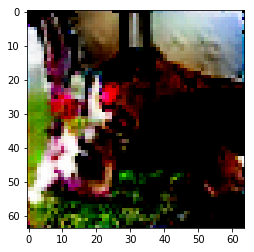

[94/200][322/644] Loss_D: 0.6883 Loss_G: 2.3765 D(x): 0.7132 D(G(z)): 0.0968 / 0.1115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[94/200][644/644] Loss_D: 0.9755 Loss_G: 2.0926 D(x): 0.3672 D(G(z)): 0.0095 / 0.1074



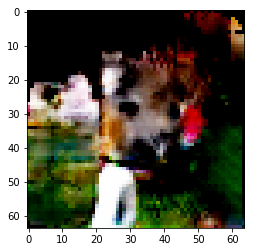

[95/200][322/644] Loss_D: 0.7042 Loss_G: 1.8679 D(x): 0.7349 D(G(z)): 0.1817 / 0.1754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[95/200][644/644] Loss_D: 0.4534 Loss_G: 4.6033 D(x): 0.7500 D(G(z)): 0.0515 / 0.0061



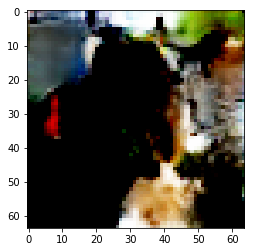

[96/200][322/644] Loss_D: 0.6204 Loss_G: 2.9311 D(x): 0.7614 D(G(z)): 0.1146 / 0.0606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[96/200][644/644] Loss_D: 1.9994 Loss_G: 2.0815 D(x): 0.1715 D(G(z)): 0.1448 / 0.2371



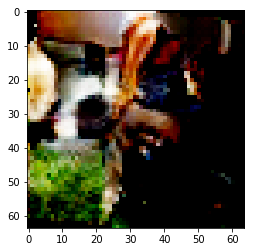

[97/200][322/644] Loss_D: 0.7210 Loss_G: 2.7831 D(x): 0.7758 D(G(z)): 0.2126 / 0.0655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[97/200][644/644] Loss_D: 0.6054 Loss_G: 5.0742 D(x): 0.7105 D(G(z)): 0.1184 / 0.0146



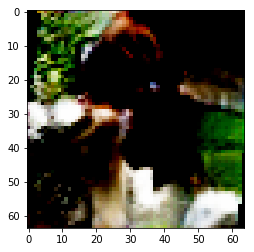

[98/200][322/644] Loss_D: 0.5443 Loss_G: 2.8475 D(x): 0.7947 D(G(z)): 0.0877 / 0.0703


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[98/200][644/644] Loss_D: 1.2295 Loss_G: 2.1818 D(x): 0.2700 D(G(z)): 0.0093 / 0.1363



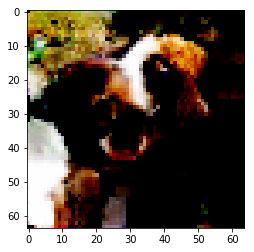

[99/200][322/644] Loss_D: 0.7420 Loss_G: 2.1487 D(x): 0.6115 D(G(z)): 0.1072 / 0.1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[99/200][644/644] Loss_D: 1.3125 Loss_G: 2.9015 D(x): 0.2631 D(G(z)): 0.0098 / 0.0863



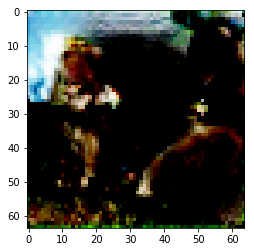

[100/200][322/644] Loss_D: 0.6095 Loss_G: 3.5382 D(x): 0.9576 D(G(z)): 0.1517 / 0.0304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[100/200][644/644] Loss_D: 0.6600 Loss_G: 3.6030 D(x): 0.6636 D(G(z)): 0.0483 / 0.0186



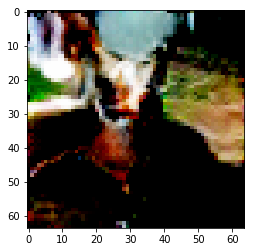

[101/200][322/644] Loss_D: 0.9135 Loss_G: 2.6574 D(x): 0.5666 D(G(z)): 0.1201 / 0.1007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[101/200][644/644] Loss_D: 0.9568 Loss_G: 4.8418 D(x): 0.5405 D(G(z)): 0.1719 / 0.0058



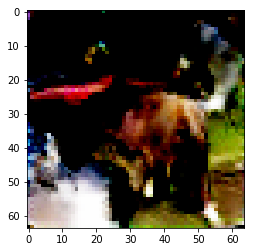

[102/200][322/644] Loss_D: 0.5412 Loss_G: 3.1891 D(x): 0.8352 D(G(z)): 0.1353 / 0.0417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[102/200][644/644] Loss_D: 1.6676 Loss_G: 1.6883 D(x): 0.3553 D(G(z)): 0.0071 / 0.2547



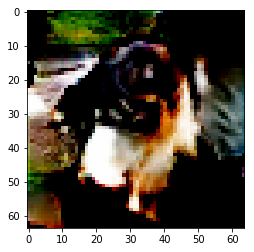

[103/200][322/644] Loss_D: 0.5804 Loss_G: 3.5970 D(x): 0.8974 D(G(z)): 0.1774 / 0.0255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[103/200][644/644] Loss_D: 0.8355 Loss_G: 2.9507 D(x): 0.5053 D(G(z)): 0.0025 / 0.0416



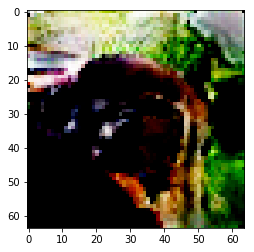

[104/200][322/644] Loss_D: 0.8959 Loss_G: 3.8541 D(x): 0.8919 D(G(z)): 0.3479 / 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[104/200][644/644] Loss_D: 1.1642 Loss_G: 1.3480 D(x): 0.4707 D(G(z)): 0.0447 / 0.2464



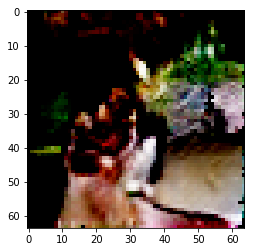

[105/200][322/644] Loss_D: 0.6669 Loss_G: 3.0144 D(x): 0.8243 D(G(z)): 0.1843 / 0.0636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[105/200][644/644] Loss_D: 1.9175 Loss_G: 1.0900 D(x): 0.1897 D(G(z)): 0.0481 / 0.3706



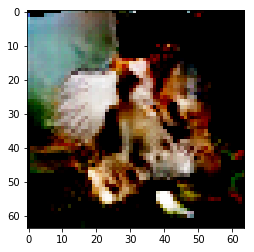

[106/200][322/644] Loss_D: 0.7065 Loss_G: 2.3311 D(x): 0.6035 D(G(z)): 0.0583 / 0.1059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[106/200][644/644] Loss_D: 1.4467 Loss_G: 5.5339 D(x): 0.3038 D(G(z)): 0.2081 / 0.0036



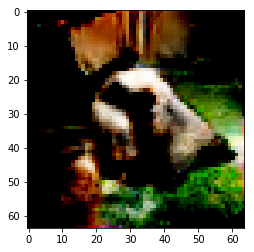

[107/200][322/644] Loss_D: 0.8385 Loss_G: 2.7490 D(x): 0.5626 D(G(z)): 0.1110 / 0.0905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[107/200][644/644] Loss_D: 0.5188 Loss_G: 4.6552 D(x): 0.9740 D(G(z)): 0.0149 / 0.0062



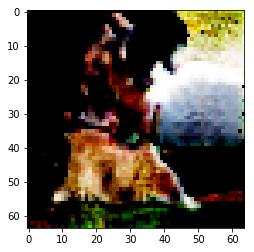

[108/200][322/644] Loss_D: 0.8137 Loss_G: 3.1028 D(x): 0.7969 D(G(z)): 0.2613 / 0.0455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[108/200][644/644] Loss_D: 1.4908 Loss_G: 20.0810 D(x): 0.7713 D(G(z)): 0.6307 / 0.0000



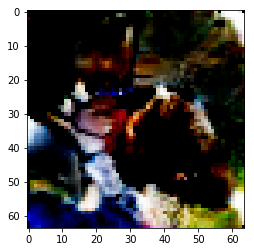

[109/200][322/644] Loss_D: 0.6086 Loss_G: 2.4266 D(x): 0.8851 D(G(z)): 0.1881 / 0.0776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[109/200][644/644] Loss_D: 1.4949 Loss_G: 1.4023 D(x): 0.3587 D(G(z)): 0.0317 / 0.2337



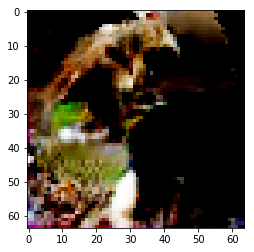

[110/200][322/644] Loss_D: 0.7086 Loss_G: 2.3388 D(x): 0.8539 D(G(z)): 0.2273 / 0.1155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[110/200][644/644] Loss_D: 0.5117 Loss_G: 5.0524 D(x): 0.8746 D(G(z)): 0.0158 / 0.0044



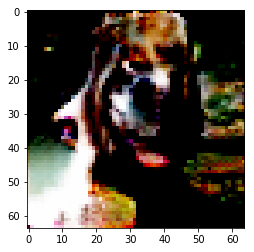

[111/200][322/644] Loss_D: 0.6682 Loss_G: 2.5219 D(x): 0.6766 D(G(z)): 0.0743 / 0.0943


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[111/200][644/644] Loss_D: 0.4528 Loss_G: 3.9636 D(x): 0.7363 D(G(z)): 0.0110 / 0.0182



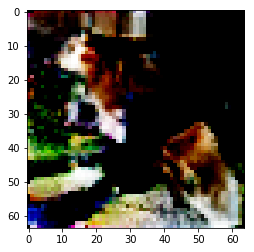

[112/200][322/644] Loss_D: 0.6679 Loss_G: 2.8332 D(x): 0.6685 D(G(z)): 0.0821 / 0.0600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[112/200][644/644] Loss_D: 0.4875 Loss_G: 5.6274 D(x): 0.8530 D(G(z)): 0.1153 / 0.0041



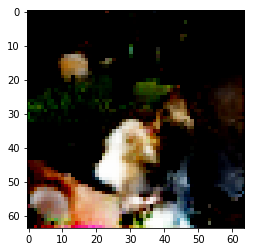

[113/200][322/644] Loss_D: 1.0201 Loss_G: 3.6385 D(x): 0.9602 D(G(z)): 0.4040 / 0.0229


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[113/200][644/644] Loss_D: 0.4652 Loss_G: 4.2217 D(x): 0.7288 D(G(z)): 0.0059 / 0.0127



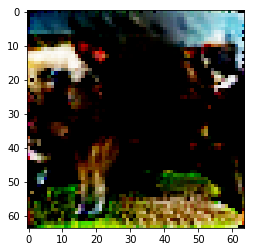

[114/200][322/644] Loss_D: 0.5871 Loss_G: 3.3691 D(x): 0.7785 D(G(z)): 0.0972 / 0.0378


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[114/200][644/644] Loss_D: 0.5133 Loss_G: 4.0659 D(x): 0.6901 D(G(z)): 0.0159 / 0.0119



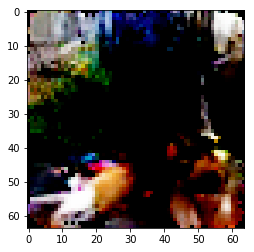

[115/200][322/644] Loss_D: 0.8352 Loss_G: 3.1443 D(x): 0.7855 D(G(z)): 0.2708 / 0.0497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[115/200][644/644] Loss_D: 1.0252 Loss_G: 3.0243 D(x): 0.5396 D(G(z)): 0.0584 / 0.0360



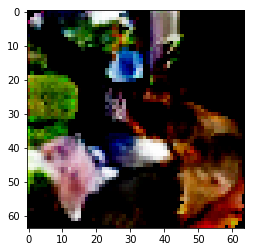

[116/200][322/644] Loss_D: 0.6463 Loss_G: 3.7596 D(x): 0.9558 D(G(z)): 0.1895 / 0.0256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[116/200][644/644] Loss_D: 2.8767 Loss_G: 1.1396 D(x): 0.0494 D(G(z)): 0.0038 / 0.3953



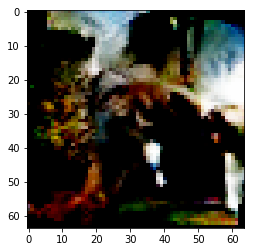

[117/200][322/644] Loss_D: 0.7075 Loss_G: 2.3158 D(x): 0.7535 D(G(z)): 0.1808 / 0.1202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[117/200][644/644] Loss_D: 2.4657 Loss_G: 7.1851 D(x): 0.2352 D(G(z)): 0.3937 / 0.0388



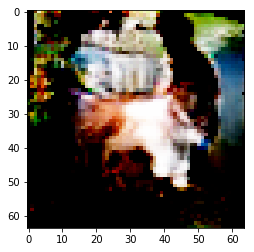

[118/200][322/644] Loss_D: 0.8221 Loss_G: 2.6264 D(x): 0.8010 D(G(z)): 0.2822 / 0.0760


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[118/200][644/644] Loss_D: 1.9147 Loss_G: 0.6809 D(x): 0.1258 D(G(z)): 0.0091 / 0.5564



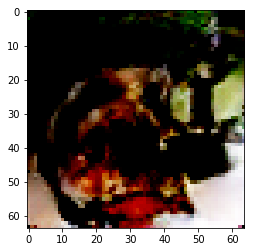

[119/200][322/644] Loss_D: 0.5730 Loss_G: 2.5190 D(x): 0.7074 D(G(z)): 0.0686 / 0.0889


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[119/200][644/644] Loss_D: 2.1184 Loss_G: 0.6609 D(x): 0.1620 D(G(z)): 0.0092 / 0.5291



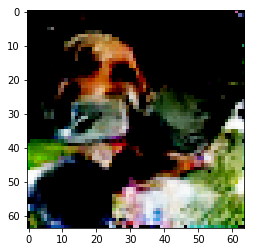

[120/200][322/644] Loss_D: 0.6692 Loss_G: 3.1970 D(x): 0.7106 D(G(z)): 0.1101 / 0.0541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[120/200][644/644] Loss_D: 1.1555 Loss_G: 14.3973 D(x): 0.8638 D(G(z)): 0.3102 / 0.0001



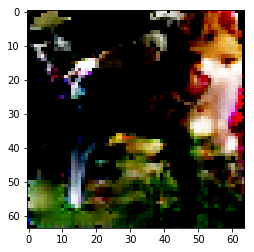

[121/200][322/644] Loss_D: 0.6460 Loss_G: 2.8742 D(x): 0.6950 D(G(z)): 0.0645 / 0.0669


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[121/200][644/644] Loss_D: 3.3215 Loss_G: 1.9022 D(x): 0.0263 D(G(z)): 0.0063 / 0.1601



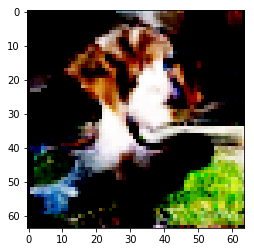

[122/200][322/644] Loss_D: 0.8031 Loss_G: 3.1638 D(x): 0.8519 D(G(z)): 0.2805 / 0.0410


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[122/200][644/644] Loss_D: 2.0540 Loss_G: 1.1472 D(x): 0.1184 D(G(z)): 0.0009 / 0.3835



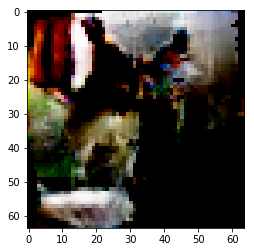

[123/200][322/644] Loss_D: 0.5776 Loss_G: 2.5345 D(x): 0.7390 D(G(z)): 0.0998 / 0.0831


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[123/200][644/644] Loss_D: 1.3776 Loss_G: 1.3999 D(x): 0.2551 D(G(z)): 0.0183 / 0.2845



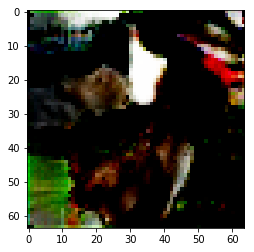

[124/200][322/644] Loss_D: 0.5127 Loss_G: 3.6337 D(x): 0.7696 D(G(z)): 0.0579 / 0.0338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[124/200][644/644] Loss_D: 1.1053 Loss_G: 9.4663 D(x): 0.5584 D(G(z)): 0.3526 / 0.0003



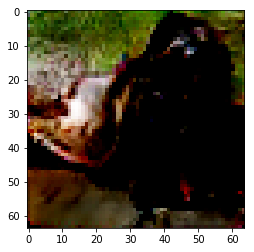

[125/200][322/644] Loss_D: 0.6281 Loss_G: 2.5909 D(x): 0.6946 D(G(z)): 0.0949 / 0.0874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[125/200][644/644] Loss_D: 2.4126 Loss_G: 1.8213 D(x): 0.0771 D(G(z)): 0.0062 / 0.1708



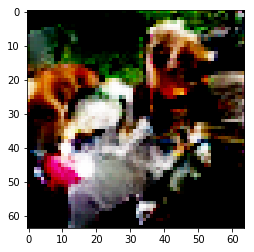

[126/200][322/644] Loss_D: 0.6772 Loss_G: 2.7625 D(x): 0.8801 D(G(z)): 0.2105 / 0.0708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[126/200][644/644] Loss_D: 0.5371 Loss_G: 6.4685 D(x): 0.9932 D(G(z)): 0.0024 / 0.0009



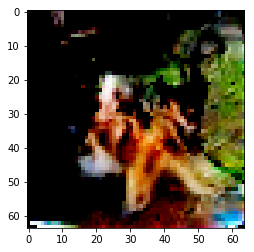

[127/200][322/644] Loss_D: 0.5838 Loss_G: 2.9444 D(x): 0.8714 D(G(z)): 0.1584 / 0.0507


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[127/200][644/644] Loss_D: 0.7934 Loss_G: 2.7630 D(x): 0.4928 D(G(z)): 0.0349 / 0.0692



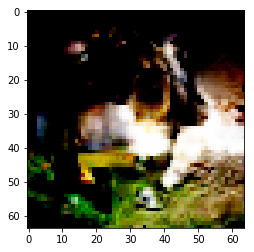

[128/200][322/644] Loss_D: 0.6028 Loss_G: 2.9286 D(x): 0.7649 D(G(z)): 0.1196 / 0.0735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[128/200][644/644] Loss_D: 0.4973 Loss_G: 4.4597 D(x): 0.7864 D(G(z)): 0.0780 / 0.0078



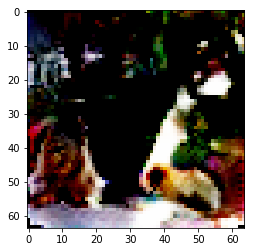

[129/200][322/644] Loss_D: 1.0388 Loss_G: 3.8710 D(x): 0.9399 D(G(z)): 0.4065 / 0.0206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[129/200][644/644] Loss_D: 0.5248 Loss_G: 4.4594 D(x): 0.7842 D(G(z)): 0.0192 / 0.0080



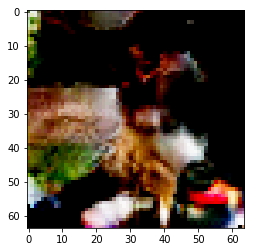

[130/200][322/644] Loss_D: 0.4959 Loss_G: 3.8444 D(x): 0.8472 D(G(z)): 0.0763 / 0.0209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[130/200][644/644] Loss_D: 0.4056 Loss_G: 4.9312 D(x): 0.9033 D(G(z)): 0.0502 / 0.0061



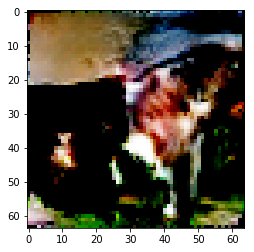

[131/200][322/644] Loss_D: 0.6384 Loss_G: 2.5141 D(x): 0.6898 D(G(z)): 0.0719 / 0.0909


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[131/200][644/644] Loss_D: 2.0002 Loss_G: 3.1666 D(x): 0.4127 D(G(z)): 0.0053 / 0.0574



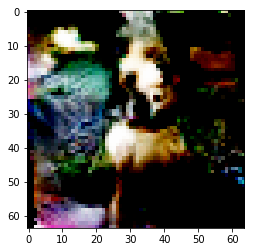

[132/200][322/644] Loss_D: 0.5447 Loss_G: 2.4683 D(x): 0.8874 D(G(z)): 0.1096 / 0.0968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[132/200][644/644] Loss_D: 0.7655 Loss_G: 2.6210 D(x): 0.4930 D(G(z)): 0.0095 / 0.1370



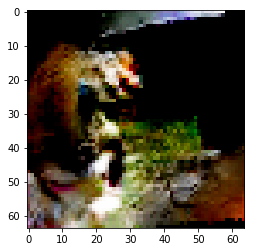

[133/200][322/644] Loss_D: 0.5329 Loss_G: 3.1857 D(x): 0.7708 D(G(z)): 0.0787 / 0.0459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[133/200][644/644] Loss_D: 1.3588 Loss_G: 1.6551 D(x): 0.2397 D(G(z)): 0.0122 / 0.2634



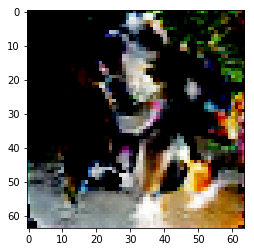

[134/200][322/644] Loss_D: 0.7232 Loss_G: 2.7939 D(x): 0.6939 D(G(z)): 0.1299 / 0.0845


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[134/200][644/644] Loss_D: 1.0224 Loss_G: 2.2638 D(x): 0.5909 D(G(z)): 0.0272 / 0.0915



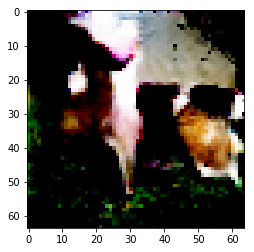

[135/200][322/644] Loss_D: 0.5178 Loss_G: 3.0170 D(x): 0.9438 D(G(z)): 0.1108 / 0.0469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[135/200][644/644] Loss_D: 3.0933 Loss_G: 0.5307 D(x): 0.0333 D(G(z)): 0.0054 / 0.6324



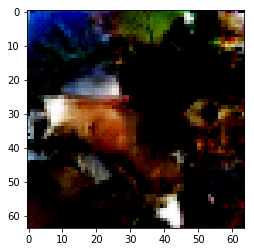

[136/200][322/644] Loss_D: 0.7694 Loss_G: 3.1479 D(x): 0.8330 D(G(z)): 0.2701 / 0.0406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[136/200][644/644] Loss_D: 1.6202 Loss_G: 0.8279 D(x): 0.2633 D(G(z)): 0.0130 / 0.4672



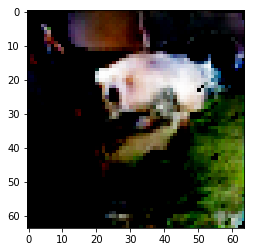

[137/200][322/644] Loss_D: 1.0484 Loss_G: 2.0489 D(x): 0.4519 D(G(z)): 0.1063 / 0.1545


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[137/200][644/644] Loss_D: 0.9916 Loss_G: 3.3252 D(x): 0.5730 D(G(z)): 0.0186 / 0.0257



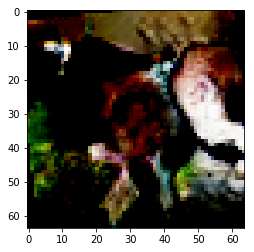

[138/200][322/644] Loss_D: 0.5387 Loss_G: 3.5662 D(x): 0.8122 D(G(z)): 0.0953 / 0.0281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[138/200][644/644] Loss_D: 0.3778 Loss_G: 2.6983 D(x): 0.8162 D(G(z)): 0.0179 / 0.0529



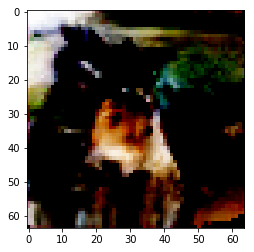

[139/200][322/644] Loss_D: 0.5384 Loss_G: 3.1530 D(x): 0.8068 D(G(z)): 0.0958 / 0.0482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[139/200][644/644] Loss_D: 0.7878 Loss_G: 10.3060 D(x): 0.6627 D(G(z)): 0.2335 / 0.0001



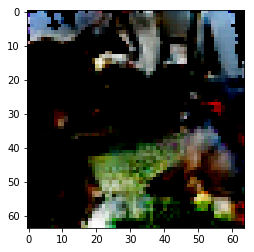

[140/200][322/644] Loss_D: 0.7871 Loss_G: 2.2052 D(x): 0.7128 D(G(z)): 0.2177 / 0.1330


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[140/200][644/644] Loss_D: 1.5618 Loss_G: 1.2739 D(x): 0.1873 D(G(z)): 0.0060 / 0.3147



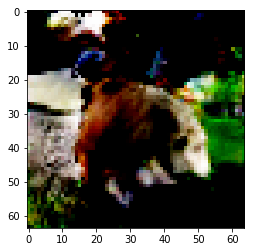

[141/200][322/644] Loss_D: 0.6640 Loss_G: 3.0937 D(x): 0.8959 D(G(z)): 0.2184 / 0.0410


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[141/200][644/644] Loss_D: 0.6119 Loss_G: 4.0984 D(x): 0.6552 D(G(z)): 0.0736 / 0.0124



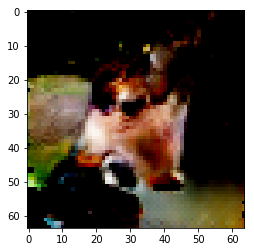

[142/200][322/644] Loss_D: 0.5244 Loss_G: 4.0574 D(x): 0.9077 D(G(z)): 0.1436 / 0.0174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[142/200][644/644] Loss_D: 2.2069 Loss_G: 2.2957 D(x): 0.1055 D(G(z)): 0.0098 / 0.2287



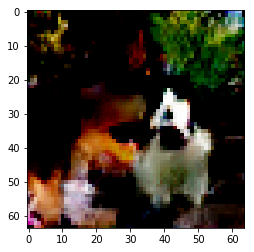

[143/200][322/644] Loss_D: 0.7138 Loss_G: 3.0666 D(x): 0.7833 D(G(z)): 0.2127 / 0.0484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[143/200][644/644] Loss_D: 0.6197 Loss_G: 5.4049 D(x): 0.6791 D(G(z)): 0.1221 / 0.0060



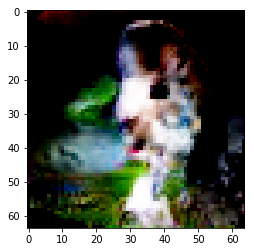

[144/200][322/644] Loss_D: 0.8701 Loss_G: 3.8536 D(x): 0.8922 D(G(z)): 0.3319 / 0.0220


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[144/200][644/644] Loss_D: 0.4197 Loss_G: 4.3771 D(x): 0.8689 D(G(z)): 0.0068 / 0.0087



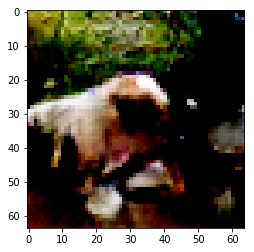

[145/200][322/644] Loss_D: 0.5720 Loss_G: 3.6451 D(x): 0.8499 D(G(z)): 0.1450 / 0.0264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[145/200][644/644] Loss_D: 2.7934 Loss_G: 1.5262 D(x): 0.0612 D(G(z)): 0.0204 / 0.3108



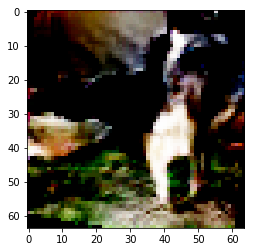

[146/200][322/644] Loss_D: 0.8517 Loss_G: 2.8257 D(x): 0.8419 D(G(z)): 0.2958 / 0.0588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[146/200][644/644] Loss_D: 1.4439 Loss_G: 2.5666 D(x): 0.3143 D(G(z)): 0.0060 / 0.0784



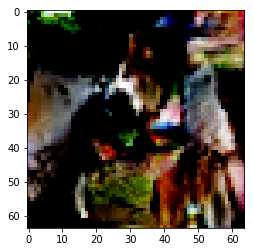

[147/200][322/644] Loss_D: 0.4637 Loss_G: 4.7050 D(x): 0.8483 D(G(z)): 0.0414 / 0.0159


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[147/200][644/644] Loss_D: 0.4256 Loss_G: 5.6411 D(x): 0.9492 D(G(z)): 0.0370 / 0.0051



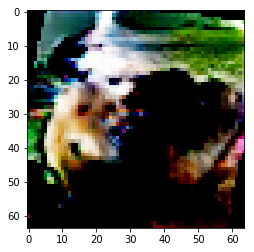

[148/200][322/644] Loss_D: 0.5934 Loss_G: 3.3735 D(x): 0.7930 D(G(z)): 0.1467 / 0.0372


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[148/200][644/644] Loss_D: 2.0327 Loss_G: 0.3861 D(x): 0.1279 D(G(z)): 0.0229 / 0.8093



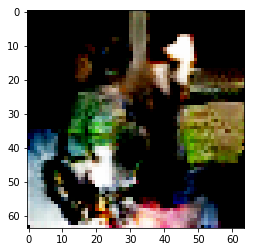

[149/200][322/644] Loss_D: 0.5659 Loss_G: 3.8563 D(x): 0.9360 D(G(z)): 0.1144 / 0.0237


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[149/200][644/644] Loss_D: 0.7550 Loss_G: 3.5517 D(x): 0.6183 D(G(z)): 0.0423 / 0.0230



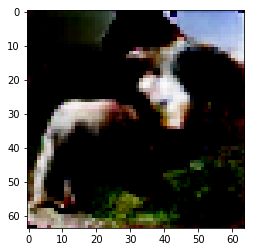

[150/200][322/644] Loss_D: 0.5733 Loss_G: 3.0990 D(x): 0.7572 D(G(z)): 0.1082 / 0.0597


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[150/200][644/644] Loss_D: 1.1643 Loss_G: 0.3304 D(x): 0.3450 D(G(z)): 0.0507 / 0.8753



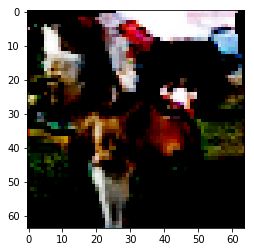

[151/200][322/644] Loss_D: 0.5565 Loss_G: 3.1318 D(x): 0.6714 D(G(z)): 0.0283 / 0.0470


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[151/200][644/644] Loss_D: 1.7966 Loss_G: 1.7378 D(x): 0.1712 D(G(z)): 0.0430 / 0.1860



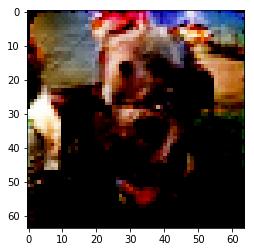

[152/200][322/644] Loss_D: 0.7049 Loss_G: 2.0987 D(x): 0.6305 D(G(z)): 0.0891 / 0.1596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[152/200][644/644] Loss_D: 1.1582 Loss_G: 2.3004 D(x): 0.3913 D(G(z)): 0.0170 / 0.0883



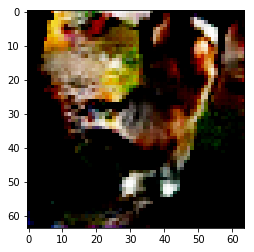

[153/200][322/644] Loss_D: 0.7193 Loss_G: 2.5862 D(x): 0.7279 D(G(z)): 0.1753 / 0.0765


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[153/200][644/644] Loss_D: 0.3608 Loss_G: 4.4020 D(x): 0.8291 D(G(z)): 0.0046 / 0.0086



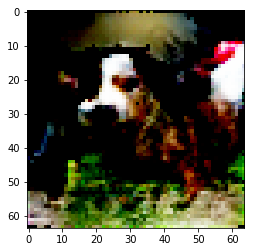

[154/200][322/644] Loss_D: 0.5497 Loss_G: 3.5104 D(x): 0.8220 D(G(z)): 0.0996 / 0.0348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[154/200][644/644] Loss_D: 1.2919 Loss_G: 4.7560 D(x): 0.3618 D(G(z)): 0.0003 / 0.0057



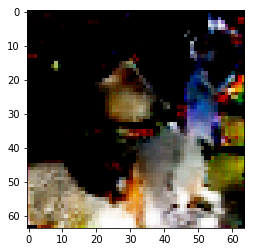

[155/200][322/644] Loss_D: 0.6020 Loss_G: 3.2020 D(x): 0.8837 D(G(z)): 0.1871 / 0.0465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[155/200][644/644] Loss_D: 0.4221 Loss_G: 5.0993 D(x): 0.8265 D(G(z)): 0.0392 / 0.0057



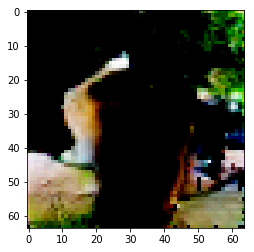

[156/200][322/644] Loss_D: 0.5208 Loss_G: 2.8321 D(x): 0.7886 D(G(z)): 0.0516 / 0.0611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[156/200][644/644] Loss_D: 0.8326 Loss_G: 3.7891 D(x): 0.5465 D(G(z)): 0.0056 / 0.0179



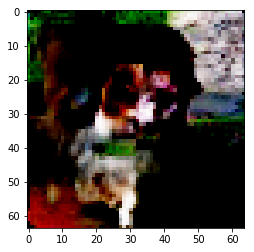

[157/200][322/644] Loss_D: 0.4696 Loss_G: 4.3894 D(x): 0.8995 D(G(z)): 0.0864 / 0.0122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[157/200][644/644] Loss_D: 0.6678 Loss_G: 6.3512 D(x): 0.7870 D(G(z)): 0.0886 / 0.0019



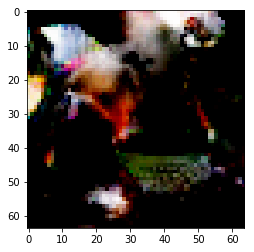

[158/200][322/644] Loss_D: 0.5858 Loss_G: 2.7539 D(x): 0.6888 D(G(z)): 0.0545 / 0.0825


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[158/200][644/644] Loss_D: 0.4291 Loss_G: 5.6289 D(x): 0.8761 D(G(z)): 0.0700 / 0.0024



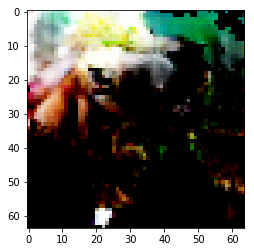

[159/200][322/644] Loss_D: 0.5434 Loss_G: 3.3605 D(x): 0.8989 D(G(z)): 0.1561 / 0.0336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[159/200][644/644] Loss_D: 1.7341 Loss_G: 2.5320 D(x): 0.2798 D(G(z)): 0.1787 / 0.1319



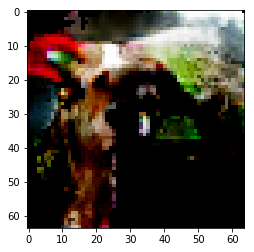

[160/200][322/644] Loss_D: 0.5255 Loss_G: 4.1088 D(x): 0.8787 D(G(z)): 0.1059 / 0.0175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[160/200][644/644] Loss_D: 1.5754 Loss_G: 1.7475 D(x): 0.2765 D(G(z)): 0.0398 / 0.1564



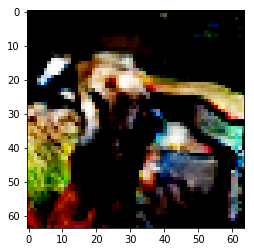

[161/200][322/644] Loss_D: 0.6704 Loss_G: 2.2668 D(x): 0.7147 D(G(z)): 0.1397 / 0.1368


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[161/200][644/644] Loss_D: 2.6162 Loss_G: 0.4835 D(x): 0.0860 D(G(z)): 0.0094 / 0.6865



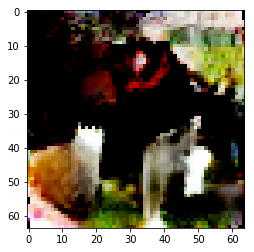

[162/200][322/644] Loss_D: 0.6469 Loss_G: 3.5826 D(x): 0.7871 D(G(z)): 0.1559 / 0.0329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[162/200][644/644] Loss_D: 0.8729 Loss_G: 4.7824 D(x): 0.5603 D(G(z)): 0.0416 / 0.0052



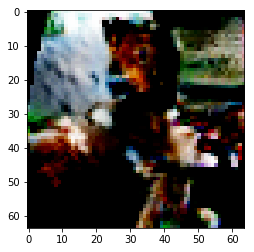

[163/200][322/644] Loss_D: 0.6936 Loss_G: 2.2251 D(x): 0.6073 D(G(z)): 0.0443 / 0.1431


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[163/200][644/644] Loss_D: 0.4627 Loss_G: 3.5871 D(x): 0.7407 D(G(z)): 0.0074 / 0.0242



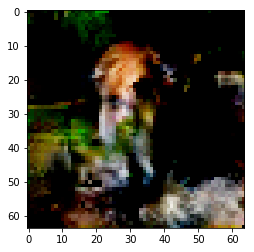

[164/200][322/644] Loss_D: 0.5217 Loss_G: 2.8246 D(x): 0.7447 D(G(z)): 0.0765 / 0.0719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[164/200][644/644] Loss_D: 0.5193 Loss_G: 8.1982 D(x): 0.9062 D(G(z)): 0.1612 / 0.0005



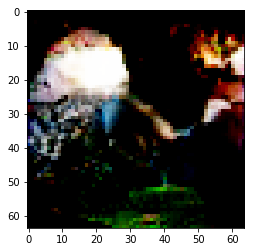

[165/200][322/644] Loss_D: 0.5940 Loss_G: 2.5433 D(x): 0.8454 D(G(z)): 0.1562 / 0.0866


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[165/200][644/644] Loss_D: 0.3938 Loss_G: 4.8761 D(x): 0.8890 D(G(z)): 0.0072 / 0.0044



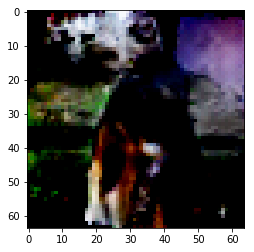

[166/200][322/644] Loss_D: 0.6133 Loss_G: 2.4297 D(x): 0.7455 D(G(z)): 0.1027 / 0.1147


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[166/200][644/644] Loss_D: 0.5929 Loss_G: 3.0529 D(x): 0.6156 D(G(z)): 0.0331 / 0.0367



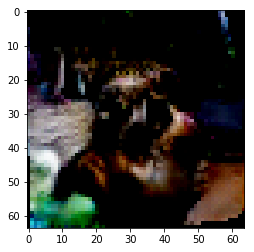

[167/200][322/644] Loss_D: 0.5940 Loss_G: 3.1465 D(x): 0.8196 D(G(z)): 0.1168 / 0.0489


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[167/200][644/644] Loss_D: 0.4364 Loss_G: 5.5500 D(x): 0.7279 D(G(z)): 0.0148 / 0.0061



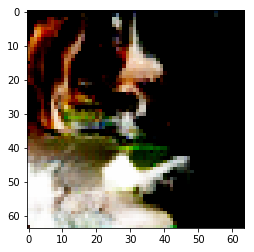

[168/200][322/644] Loss_D: 0.5461 Loss_G: 4.0131 D(x): 0.9504 D(G(z)): 0.1103 / 0.0210


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[168/200][644/644] Loss_D: 1.5922 Loss_G: 2.5856 D(x): 0.3834 D(G(z)): 0.0037 / 0.0980



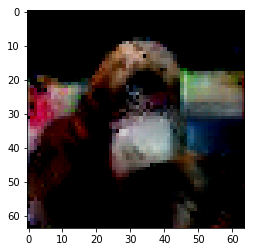

[169/200][322/644] Loss_D: 0.9232 Loss_G: 1.5547 D(x): 0.5805 D(G(z)): 0.1144 / 0.2493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[169/200][644/644] Loss_D: 0.5303 Loss_G: 4.2951 D(x): 0.7742 D(G(z)): 0.0221 / 0.0135



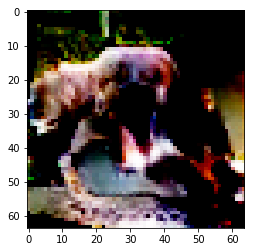

[170/200][322/644] Loss_D: 1.0770 Loss_G: 2.1962 D(x): 0.3926 D(G(z)): 0.0358 / 0.1475


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[170/200][644/644] Loss_D: 1.2417 Loss_G: 3.1308 D(x): 0.5444 D(G(z)): 0.0473 / 0.0399



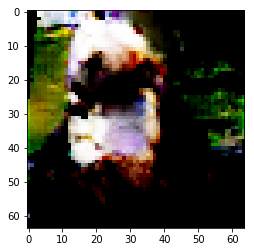

[171/200][322/644] Loss_D: 0.6614 Loss_G: 3.6430 D(x): 0.9242 D(G(z)): 0.1713 / 0.0298


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[171/200][644/644] Loss_D: 0.3670 Loss_G: 5.7153 D(x): 0.9561 D(G(z)): 0.0130 / 0.0021



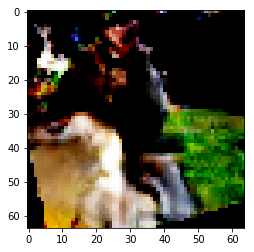

[172/200][322/644] Loss_D: 0.9140 Loss_G: 2.3591 D(x): 0.5501 D(G(z)): 0.0560 / 0.1152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[172/200][644/644] Loss_D: 0.5522 Loss_G: 5.0277 D(x): 0.7022 D(G(z)): 0.0033 / 0.0063



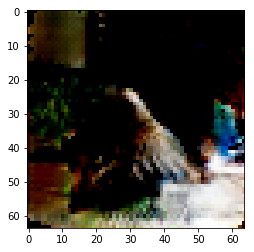

[173/200][322/644] Loss_D: 0.5779 Loss_G: 3.1696 D(x): 0.6865 D(G(z)): 0.0348 / 0.0585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[173/200][644/644] Loss_D: 3.3499 Loss_G: 1.8095 D(x): 0.0503 D(G(z)): 0.1809 / 0.4211



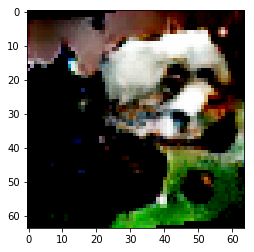

[174/200][322/644] Loss_D: 0.7824 Loss_G: 2.5274 D(x): 0.7317 D(G(z)): 0.2038 / 0.0843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[174/200][644/644] Loss_D: 0.4697 Loss_G: 6.5866 D(x): 0.9278 D(G(z)): 0.0507 / 0.0023



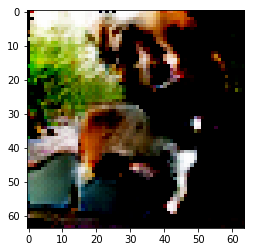

[175/200][322/644] Loss_D: 0.4556 Loss_G: 3.7525 D(x): 0.8853 D(G(z)): 0.0731 / 0.0299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[175/200][644/644] Loss_D: 0.5342 Loss_G: 6.3293 D(x): 0.9447 D(G(z)): 0.1002 / 0.0017



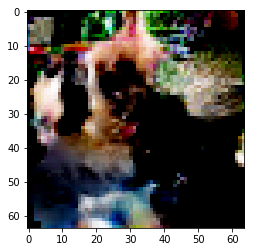

[176/200][322/644] Loss_D: 0.5214 Loss_G: 3.5100 D(x): 0.8377 D(G(z)): 0.0857 / 0.0304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[176/200][644/644] Loss_D: 1.4897 Loss_G: 7.4566 D(x): 0.3500 D(G(z)): 0.2367 / 0.0003



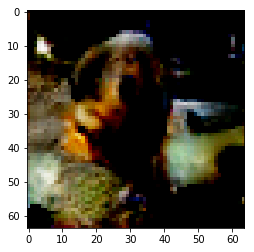

[177/200][322/644] Loss_D: 0.6099 Loss_G: 2.8976 D(x): 0.6898 D(G(z)): 0.0746 / 0.0580


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[177/200][644/644] Loss_D: 1.4124 Loss_G: 2.4520 D(x): 0.4084 D(G(z)): 0.0535 / 0.0752



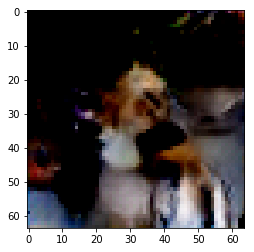

[178/200][322/644] Loss_D: 0.6318 Loss_G: 3.8764 D(x): 0.9256 D(G(z)): 0.1890 / 0.0218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[178/200][644/644] Loss_D: 2.0662 Loss_G: 1.5880 D(x): 0.1106 D(G(z)): 0.0039 / 0.3277



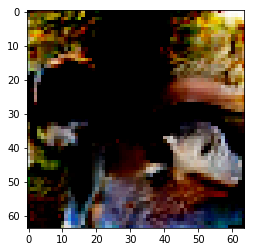

[179/200][322/644] Loss_D: 0.5285 Loss_G: 2.6050 D(x): 0.7907 D(G(z)): 0.0965 / 0.1017


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[179/200][644/644] Loss_D: 0.8012 Loss_G: 5.1703 D(x): 0.5589 D(G(z)): 0.0013 / 0.0108



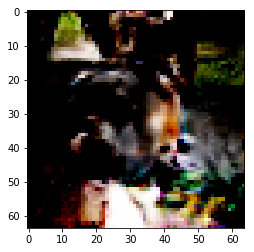

[180/200][322/644] Loss_D: 0.4459 Loss_G: 3.3996 D(x): 0.8788 D(G(z)): 0.0576 / 0.0339


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[180/200][644/644] Loss_D: 1.8760 Loss_G: 3.6847 D(x): 0.2782 D(G(z)): 0.1179 / 0.0850



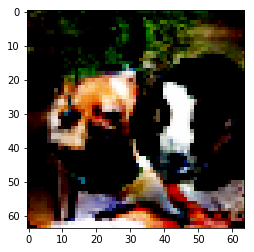

[181/200][322/644] Loss_D: 0.6111 Loss_G: 3.5813 D(x): 0.9331 D(G(z)): 0.1588 / 0.0304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[181/200][644/644] Loss_D: 0.3555 Loss_G: 4.3208 D(x): 0.9026 D(G(z)): 0.0189 / 0.0084



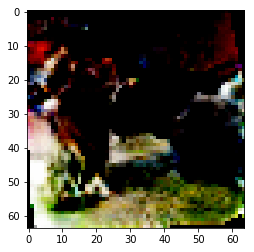

[182/200][322/644] Loss_D: 0.4954 Loss_G: 4.5081 D(x): 0.8919 D(G(z)): 0.0471 / 0.0115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[182/200][644/644] Loss_D: 1.3695 Loss_G: 0.7362 D(x): 0.2844 D(G(z)): 0.0372 / 0.4877



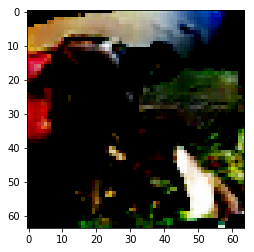

[183/200][322/644] Loss_D: 0.4866 Loss_G: 4.4882 D(x): 0.9455 D(G(z)): 0.0761 / 0.0137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[183/200][644/644] Loss_D: 0.7252 Loss_G: 5.0514 D(x): 0.5552 D(G(z)): 0.0031 / 0.0082



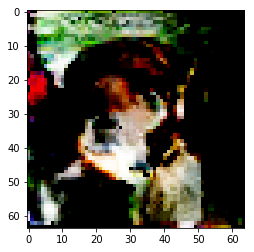

[184/200][322/644] Loss_D: 0.5801 Loss_G: 2.6763 D(x): 0.6768 D(G(z)): 0.0293 / 0.0713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[184/200][644/644] Loss_D: 2.0200 Loss_G: 0.4036 D(x): 0.2051 D(G(z)): 0.0080 / 0.7444



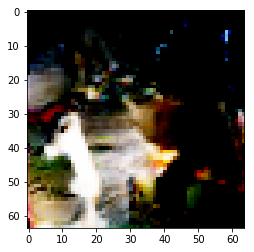

[185/200][322/644] Loss_D: 0.9210 Loss_G: 3.0238 D(x): 0.7624 D(G(z)): 0.2771 / 0.0540


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[185/200][644/644] Loss_D: 1.7273 Loss_G: 1.3977 D(x): 0.2205 D(G(z)): 0.0384 / 0.2359



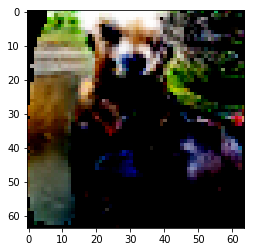

[186/200][322/644] Loss_D: 0.5182 Loss_G: 4.0344 D(x): 0.9072 D(G(z)): 0.1064 / 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[186/200][644/644] Loss_D: 1.1450 Loss_G: 16.1129 D(x): 0.8900 D(G(z)): 0.3274 / 0.0001



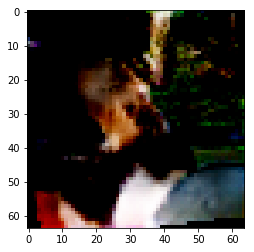

[187/200][322/644] Loss_D: 0.6174 Loss_G: 2.7632 D(x): 0.7163 D(G(z)): 0.1038 / 0.0818


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[187/200][644/644] Loss_D: 0.9462 Loss_G: 2.0098 D(x): 0.4308 D(G(z)): 0.0108 / 0.1663



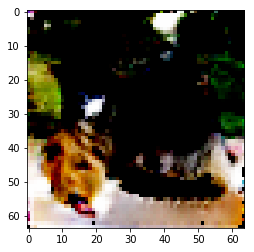

[188/200][322/644] Loss_D: 0.4471 Loss_G: 3.6353 D(x): 0.8902 D(G(z)): 0.0606 / 0.0260


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[188/200][644/644] Loss_D: 0.7794 Loss_G: 4.9518 D(x): 0.8836 D(G(z)): 0.0773 / 0.0046



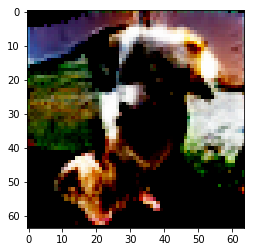

[189/200][322/644] Loss_D: 0.6237 Loss_G: 3.4562 D(x): 0.8682 D(G(z)): 0.1820 / 0.0330


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[189/200][644/644] Loss_D: 0.5415 Loss_G: 4.8505 D(x): 0.9666 D(G(z)): 0.0599 / 0.0048



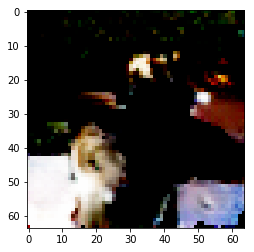

[190/200][322/644] Loss_D: 0.6270 Loss_G: 3.0348 D(x): 0.9241 D(G(z)): 0.1710 / 0.0503


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[190/200][644/644] Loss_D: 1.7595 Loss_G: 1.7012 D(x): 0.2023 D(G(z)): 0.0483 / 0.1763



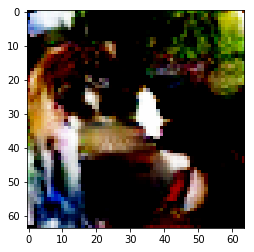

[191/200][322/644] Loss_D: 0.4696 Loss_G: 3.5421 D(x): 0.9144 D(G(z)): 0.0403 / 0.0426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[191/200][644/644] Loss_D: 3.7613 Loss_G: 1.0274 D(x): 0.0232 D(G(z)): 0.0793 / 0.5138



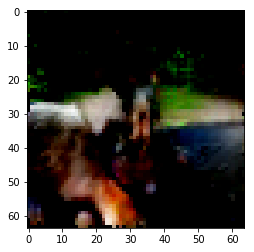

[192/200][322/644] Loss_D: 0.4919 Loss_G: 3.7320 D(x): 0.7975 D(G(z)): 0.0567 / 0.0465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[192/200][644/644] Loss_D: 0.5070 Loss_G: 6.2025 D(x): 0.9579 D(G(z)): 0.0993 / 0.0016



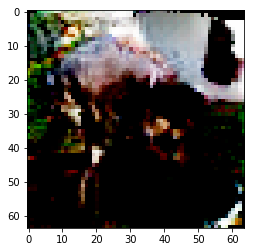

[193/200][322/644] Loss_D: 0.5244 Loss_G: 3.0798 D(x): 0.7321 D(G(z)): 0.0496 / 0.0512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[193/200][644/644] Loss_D: 0.5403 Loss_G: 3.8488 D(x): 0.7386 D(G(z)): 0.0298 / 0.0168



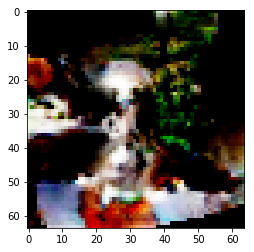

[194/200][322/644] Loss_D: 0.5204 Loss_G: 2.6797 D(x): 0.7854 D(G(z)): 0.0788 / 0.0790


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[194/200][644/644] Loss_D: 3.2866 Loss_G: 2.9850 D(x): 0.0557 D(G(z)): 0.0030 / 0.1484



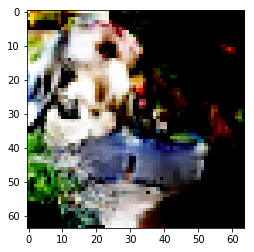

[195/200][322/644] Loss_D: 0.5342 Loss_G: 4.0460 D(x): 0.9213 D(G(z)): 0.1122 / 0.0197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[195/200][644/644] Loss_D: 0.5273 Loss_G: 5.9751 D(x): 0.7316 D(G(z)): 0.0848 / 0.0017



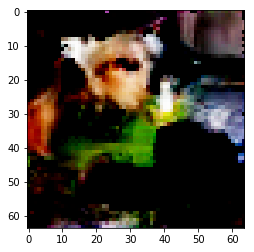

[196/200][322/644] Loss_D: 0.5926 Loss_G: 2.8180 D(x): 0.8916 D(G(z)): 0.1668 / 0.0626


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[196/200][644/644] Loss_D: 0.5360 Loss_G: 6.8915 D(x): 0.8816 D(G(z)): 0.1142 / 0.0010



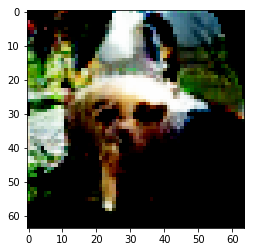

[197/200][322/644] Loss_D: 0.5388 Loss_G: 3.3143 D(x): 0.8744 D(G(z)): 0.1255 / 0.0351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[197/200][644/644] Loss_D: 0.9144 Loss_G: 3.2514 D(x): 0.5720 D(G(z)): 0.0322 / 0.0872



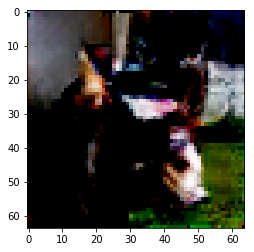

[198/200][322/644] Loss_D: 0.6641 Loss_G: 3.6266 D(x): 0.8933 D(G(z)): 0.2212 / 0.0217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[198/200][644/644] Loss_D: 1.0709 Loss_G: 1.5765 D(x): 0.3243 D(G(z)): 0.0064 / 0.1993



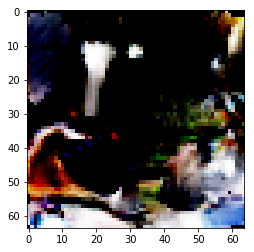

[199/200][322/644] Loss_D: 0.4911 Loss_G: 3.1510 D(x): 0.7806 D(G(z)): 0.0513 / 0.0414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[199/200][644/644] Loss_D: 0.4643 Loss_G: 6.2835 D(x): 0.9480 D(G(z)): 0.1095 / 0.0014



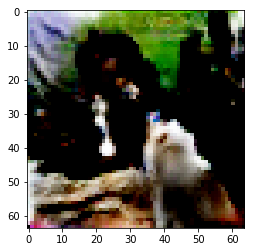

[200/200][322/644] Loss_D: 0.7053 Loss_G: 3.3290 D(x): 0.7285 D(G(z)): 0.1581 / 0.0439


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[200/200][644/644] Loss_D: 1.9684 Loss_G: 0.5446 D(x): 0.2130 D(G(z)): 0.0093 / 0.6951



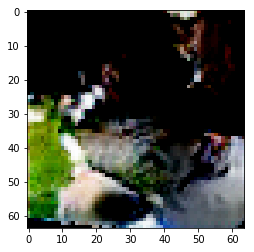

In [0]:
for epoch in range(epochs):
    
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    show_generated_img()

In [0]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = netG(gen_z).to("cpu").clone().detach()
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

In [0]:


fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)

